# <b> Glacier visualizations (Updated 3/5/22)

Molly Arndt, Middlebury College

### <b> Setting up OGGM

In [308]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely.geometry as shpg

### <b> Visualizing basins and glaciers

<b> <i> Selecting glaciers

In [2]:
from oggm import cfg, utils, workflow, tasks, graphics

In [3]:
# Download glacier outlines
utils.get_rgi_dir(version='62')  # path to the data after download

'/home/ulteelab/OGGM/rgi/RGIV62'

In [4]:
# Get rgi region file for region 16 (South America)
fr = utils.get_rgi_region_file(16, version='62')

In [5]:
# Read file as as geopandas
gdf = gpd.read_file(fr)

In [6]:
# Add basin shapefile
path = '~/Documents/Molly-thesis/Data/Basin_shapefiles/output/LaPaz_dissolved.shp' 
basin = gpd.read_file(path)

In [7]:
# Select glaciers within the basin
in_bas = [basin.geometry.contains(shpg.Point(x, y))[0] for
          (x, y) in zip(gdf.CenLon, gdf.CenLat)]
gdf_sel = gdf.loc[in_bas]

In [8]:
# Select rgi id's from the gdf_sel file
rgi_ids = gdf_sel['RGIId']

<b> <i> Visualizing basins and glaciers

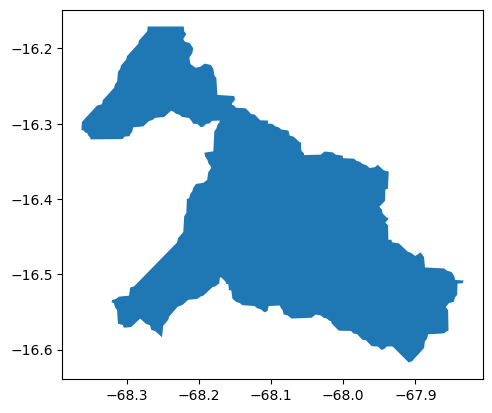

In [10]:
# Plot basin outline
basin.plot();

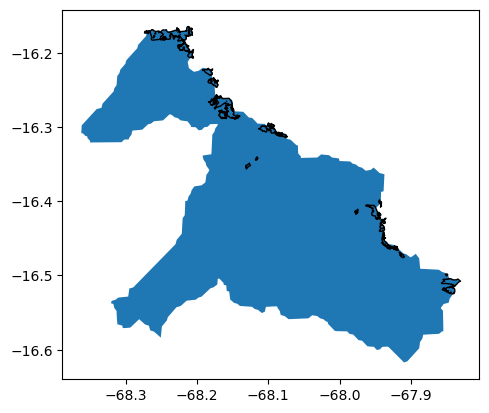

In [11]:
# Plot basin outline with glacier outlines
ax = basin.plot();
gdf_sel.plot(ax=ax, edgecolor='k');

In [13]:
# Calculate glacier area
'Glacier area in La Paz basins: {} km2'.format(gdf_sel.Area.sum())

'Glacier area in La Paz basins: 26.273999999999997 km2'

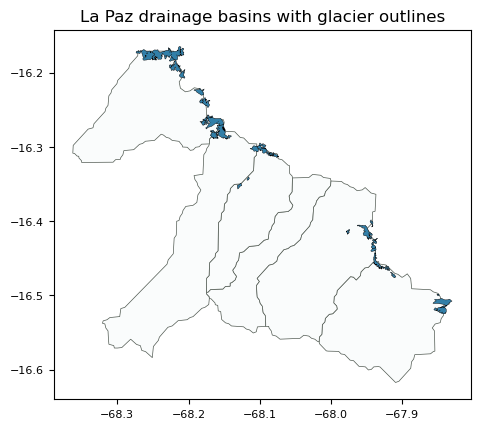

In [63]:
# Slightly different color scheme
path = '~/Documents/Molly-thesis/Data/Basin_shapefiles/output/LaPaz_basins.shp' #this needs to link to an actual shapefile
basin_ind = gpd.read_file(path)

ax = basin_ind.plot(color='#fafcfc', edgecolor='#505951', linewidth=0.5);
gdf_sel.plot(ax=ax, edgecolor='k', color='#327fa8', linewidth=0.3);
plt.title('La Paz drainage basins with glacier outlines');
ax.tick_params(axis='both', labelsize=8)

#plt.savefig('Figures/Basins/La_Paz_basins.png', bbox_inches='tight')

<b> <i> Visualizing problematic glaciers

In [30]:
# Identify the RGI IDs for problem glaciers
broken_glaciers = ["RGI60-16.00505", 
                   "RGI60-16.00506", 
                   "RGI60-16.00528", 
                   "RGI60-16.00530", 
                   "RGI60-16.00550", 
                   "RGI60-16.00595", 
                   "RGI60-16.00596", 
                   "RGI60-16.00610"]

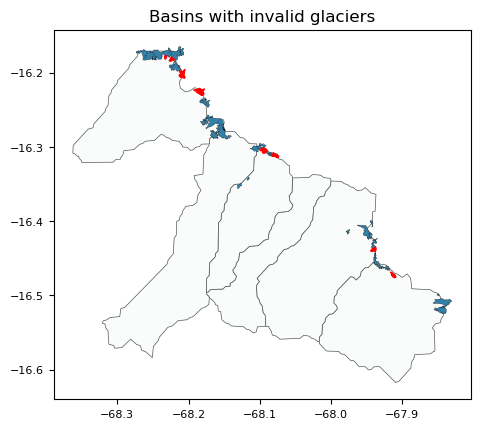

In [70]:
ax = basin_ind.plot(color='#fafcfc', edgecolor='#505951', linewidth=0.5);
al = utils.get_rgi_glacier_entities(broken_glaciers, version='62')

gdf_sel.plot(ax=ax, color="#327fa8", edgecolor="k", linewidth=0.2)
al.plot(ax=ax, color='r', edgecolor='r');
plt.title('Basins with invalid glaciers');
ax.tick_params(axis='both', labelsize=8)

#plt.savefig('Figures/Basins/La_Paz_invalid_glaciers.png', bbox_inches='tight')

In [36]:
'Area of glaciers with invalid geometries: {} km2'.format(al.Area.sum())

'Area of glaciers with invalid geometries: 2.8470000000000004 km2'

## <b> Defining functions

In [9]:
# Make a summed series for each gcm
def make_summed_series(fpath_stem, which_date, which_gcm, which_rcp):
    this_fpath = fpath_stem+'{}-gcm_data_{}_{}_compiled_output.nc'.format(which_date, which_gcm, which_rcp)
    this_ds = xr.open_dataset(this_fpath)
    melt1 = this_ds.melt_on_glacier
    melt2 = this_ds.melt_off_glacier
    melt3 = this_ds.liq_prcp_off_glacier
    melt4 = this_ds.liq_prcp_on_glacier
    
    this_sum = melt1.sum(dim='rgi_id').dropna(dim='time') + melt2.sum(dim='rgi_id').dropna(dim='time') + melt3.sum(dim='rgi_id').dropna(dim='time') + melt4.sum(dim='rgi_id').dropna(dim='time')
    nonzero_sum = this_sum.where(this_sum!=0, drop=True)
    nonzero_sum *= 1e-9
    return nonzero_sum

In [10]:
# Function for good gcms
def process_all_rcps(which_gcm, fpath_stem, which_date, rcp_list=['rcp26', 'rcp45', 'rcp60', 'rcp85']):
    gcm = which_gcm
    base_fpath = fpath_stem
    date = which_date
    all_series = []
    for rcp in rcp_list:
        s = make_summed_series(which_gcm=gcm, which_rcp=rcp, fpath_stem=base_fpath, which_date=date)
        all_series.append(s)
    
    return all_series

In [11]:
# Making this function apply to 3 rcps no matter the gcm
# poorly_behaved = ['CNRM-CM5', 'CanESM2', 'MPI-ESM-LR']
def process_3_rcps(which_gcm, fpath_stem, which_date, rcp_list=['rcp26', 'rcp45', 'rcp85']):
    gcm = which_gcm
    base_fpath = fpath_stem
    date = which_date
    all_series = []
    for rcp in rcp_list:
        s = make_summed_series(which_gcm=gcm, which_rcp=rcp, fpath_stem=base_fpath, which_date=date)
        all_series.append(s)
    
    return all_series

## <b> Using functions

In [ ]:
# Open the file output for a model run to see what variables look like!
paths = '~/Documents/Molly-thesis/Data/2023-01-12-gcm_data_CCSM4_rcp26_compiled_output.nc'
this_ds = xr.open_dataset(paths)

I think I could just write a for loop that would do this for me? But would I get the output?

### This next section is outdated and includes code to bring in each GCM's data individually

Text(0.5, 1.0, 'Runoff by RCP scenario for GCM CCSM4')

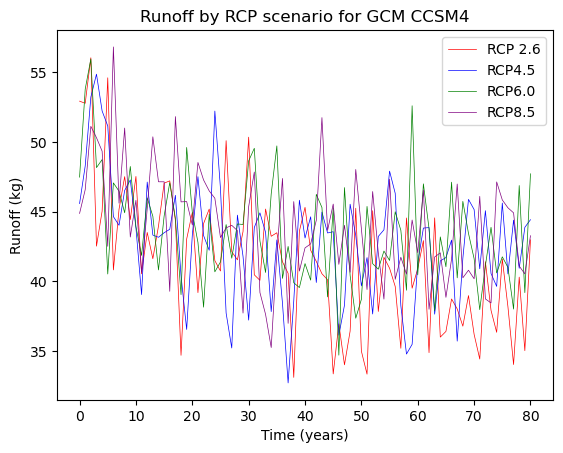

In [75]:
# Apply the two functions for ccsm4
base_fpath = '~/Documents/Molly-thesis/Data/'

ccsm_results = process_all_rcps(which_gcm='CCSM4', fpath_stem=base_fpath, which_date='2023-01-12')

which_gcm='CCSM4'
rcp_labels = ['RCP 2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5'] 
colors = ['red', 'blue', 'green', 'purple' ]

fig, ax = plt.subplots()
for i, r in enumerate(ccsm_results):
    ax.plot(r, label=rcp_labels[i], color=colors[i], linewidth=0.5)
#plt.plot(ccsm_results[0]) # this will highlight one of your rcp scenarios
plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
plt.title('Runoff by RCP scenario for GCM {}'.format(which_gcm))

In [ ]:
# Apply the two functions for ccsm4
base_fpath = '~/Documents/Molly-thesis/Data/'

csiro_results = process_all_rcps(which_gcm='CSIRO-Mk3-6-0', which_date='2023-01-17', fpath_stem=base_fpath)

which_gcm='CSIRO-Mk3-6-0'
rcp_labels = ['RCP 2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5'] 
colors = ['red', 'blue', 'green', 'purple' ]

fig, ax = plt.subplots()
for i, r in enumerate(csiro_results):
    ax.plot(r, label=rcp_labels[i], color=colors[i], linewidth=0.5)
#plt.plot(ccsm_results[0]) # this will highlight one of your rcp scenarios
plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
plt.title('Runoff by RCP scenario for GCM {}'.format(which_gcm))

In [ ]:
# Make a test to see if removing an rcp works
# Update: it works!
base_fpath = '~/Documents/Molly-thesis/Data/'

CNRM_results = process_3_rcps(which_gcm='CNRM-CM5', which_date='2023-01-23', fpath_stem=base_fpath)

which_gcm='CNRM-CM5'
rcp_labels = ['RCP 2.6', 'RCP4.5', 'RCP8.5'] 
colors = ['red', 'blue', 'purple' ]

fig, ax = plt.subplots()
for i, r in enumerate(CNRM_results):
    ax.plot(r, label=rcp_labels[i], color=colors[i], linewidth=0.5)
#plt.plot(ccsm_results[0]) # this will highlight one of your rcp scenarios
plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
plt.title('Runoff by RCP scenario for GCM {}'.format(which_gcm))

In [ ]:
base_fpath = '~/Documents/Molly-thesis/Data/'

CanESM2_results = process_3_rcps(which_gcm='CanESM2', which_date='2023-01-23', fpath_stem=base_fpath)

which_gcm='CanESM2'
rcp_labels = ['RCP 2.6', 'RCP4.5', 'RCP8.5'] 
colors = ['red', 'blue', 'purple' ]

fig, ax = plt.subplots()
for i, r in enumerate(CanESM2_results):
    ax.plot(r, label=rcp_labels[i], color=colors[i], linewidth=0.5)
#plt.plot(ccsm_results[0]) # this will highlight one of your rcp scenarios
plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
plt.title('Runoff by RCP scenario for GCM {}'.format(which_gcm))

In [ ]:
base_fpath = '~/Documents/Molly-thesis/Data/'

gfdl_cm3_results = process_all_rcps(which_gcm='GFDL-CM3', which_date='2023-01-23', fpath_stem=base_fpath)

which_gcm='GFDL-CM3'
rcp_labels = ['RCP 2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5'] 
colors = ['red', 'blue', 'green', 'purple' ]

fig, ax = plt.subplots()
for i, r in enumerate(gfdl_cm3_results):
    ax.plot(r, label=rcp_labels[i], color=colors[i], linewidth=0.5)
#plt.plot(ccsm_results[0]) # this will highlight one of your rcp scenarios
plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
plt.title('Runoff by RCP scenario for GCM {}'.format(which_gcm))

In [ ]:
base_fpath = '~/Documents/Molly-thesis/Data/'

cfdl_ems2g_results = process_all_rcps(which_gcm='GFDL-ESM2G', which_date='2023-01-23', fpath_stem=base_fpath)

which_gcm='GFDL-ESM2G'
rcp_labels = ['RCP 2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5'] 
colors = ['red', 'blue', 'green', 'purple' ]

fig, ax = plt.subplots()
for i, r in enumerate(cfdl_ems2g_results):
    ax.plot(r, label=rcp_labels[i], color=colors[i], linewidth=0.5)
#plt.plot(ccsm_results[0]) # this will highlight one of your rcp scenarios
plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
plt.title('Runoff by RCP scenario for GCM {}'.format(which_gcm))

In [ ]:
base_fpath = '~/Documents/Molly-thesis/Data/'

giss_results = process_all_rcps(which_gcm='GISS-E2-R', which_date='2023-01-23', fpath_stem=base_fpath)

which_gcm='GISS-E2-R'
rcp_labels = ['RCP 2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5'] 
colors = ['red', 'blue', 'green', 'purple' ]

fig, ax = plt.subplots()
for i, r in enumerate(giss_results):
    ax.plot(r, label=rcp_labels[i], color=colors[i], linewidth=0.5)
#plt.plot(ccsm_results[0]) # this will highlight one of your rcp scenarios
plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
plt.title('Runoff by RCP scenario for GCM {}'.format(which_gcm))

In [ ]:
base_fpath = '~/Documents/Molly-thesis/Data/'

ipsl_results = process_all_rcps(which_gcm='IPSL-CM5A-LR', which_date='2023-01-25', fpath_stem=base_fpath)

which_gcm='IPSL-CM5A-LR'
rcp_labels = ['RCP 2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5'] 
colors = ['red', 'blue', 'green', 'purple' ]

fig, ax = plt.subplots()
for i, r in enumerate(ipsl_results):
    ax.plot(r, label=rcp_labels[i], color=colors[i], linewidth=0.5)
#plt.plot(ccsm_results[0]) # this will highlight one of your rcp scenarios
plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
plt.title('Runoff by RCP scenario for GCM {}'.format(which_gcm))

In [ ]:
base_fpath = '~/Documents/Molly-thesis/Data/'

mpi_results = process_3_rcps(which_gcm='MPI-ESM-LR', which_date='2023-01-25', fpath_stem=base_fpath)

which_gcm='MPI-ESM-LR'
rcp_labels = ['RCP 2.6', 'RCP4.5', 'RCP8.5'] 
colors = ['red', 'blue', 'purple' ]

fig, ax = plt.subplots()
for i, r in enumerate(mpi_results):
    ax.plot(r, label=rcp_labels[i], color=colors[i], linewidth=0.5)
#plt.plot(ccsm_results[0]) # this will highlight one of your rcp scenarios
plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
plt.title('Runoff by RCP scenario for GCM {}'.format(which_gcm))

In [ ]:
base_fpath = '~/Documents/Molly-thesis/Data/'

norESM1_results = process_all_rcps(which_gcm='NorESM1-M', which_date='2023-01-25', fpath_stem=base_fpath)

which_gcm='NorESM1-M'
rcp_labels = ['RCP 2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5'] 
colors = ['red', 'blue', 'green', 'purple' ]

fig, ax = plt.subplots()
for i, r in enumerate(norESM1_results):
    ax.plot(r, label=rcp_labels[i], color=colors[i], linewidth=0.5)
#plt.plot(ccsm_results[0]) # this will highlight one of your rcp scenarios
plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
plt.title('Runoff by RCP scenario for GCM {}'.format(which_gcm))

In [ ]:
# try two with Norsm1
base_fpath = '~/Documents/Molly-thesis/Data/'

norESM1_results_2 = process_all_rcps(which_gcm='NorESM1-M', which_date='2023-01-29', fpath_stem=base_fpath)

which_gcm='NorESM1-M'
rcp_labels = ['RCP 2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5'] 
colors = ['red', 'blue', 'green', 'purple' ]

fig, ax = plt.subplots()
for i, r in enumerate(norESM1_results_2):
    ax.plot(r, label=rcp_labels[i], color=colors[i], linewidth=0.5)
#plt.plot(ccsm_results[0]) # this will highlight one of your rcp scenarios
plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
plt.title('Runoff by RCP scenario for GCM {}'.format(which_gcm))

### Similarly, this section contains relatively outdated code, although the rcp_dict code is still needed

## RCP 2.6 figure w/mean

In [12]:
# Make a dictionary for rcp26 values
rcp26_dict = {}

gcm_list = ['CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'MPI-ESM-LR', 'NorESM1-M']
date_list = ['2023-01-12', '2023-01-23', '2023-01-17', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-25', '2023-01-25', '2023-01-25']

base = '~/Documents/Molly-thesis/Data/'
rcp='rcp26'

x=0

for gcm in gcm_list:
    rcp26_values = make_summed_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
    k = '{}'.format(gcm)
    rcp26_dict[k]=rcp26_values
    x += 1

# rcp26_dict.keys()

In [13]:
rcp26_df = pd.DataFrame(rcp26_dict)

rcp26_df['mean'] = rcp26_df.transpose().mean()
#rcp_mean = rcp26_df.transpose().rolling(window=4).mean()

In [14]:
rcp26_dict.keys()

dict_keys(['CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'MPI-ESM-LR', 'NorESM1-M'])

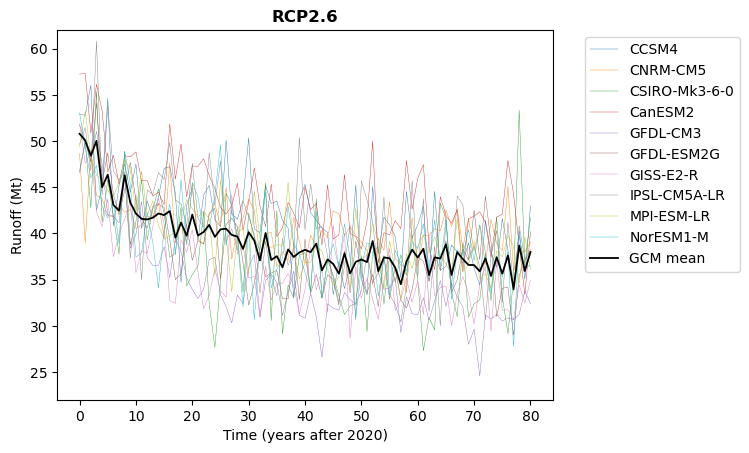

In [218]:
fig, ax = plt.subplots()
    
for k in rcp26_dict.keys():
    to_plot = rcp26_dict[k]
    ax.plot(to_plot, linewidth=0.3, label=k)
ax.plot(rcp26_df['mean'], color='k', label='GCM mean', linewidth=1.3);
plt.legend(bbox_to_anchor=(1.05, 1));
plt.xlabel('Time (years after 2020)');
plt.ylabel('Runoff (Mt)');
plt.ylim([22,62]);
plt.title('RCP2.6', fontweight='bold');

#plt.savefig('Figures/Annual/rcp26_mean_runoff_wGCMs.png', bbox_inches='tight')

## RCP 4.5 figure w/mean

In [15]:
# Make a dictionary for rcp45 values
rcp45_dict = {}

gcm_list = ['CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'MPI-ESM-LR', 'NorESM1-M']
date_list = ['2023-01-12', '2023-01-23', '2023-01-17', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-25', '2023-01-25', '2023-01-25']

base = '~/Documents/Molly-thesis/Data/'
rcp='rcp45'

x=0

for gcm in gcm_list:
    rcp45_values = make_summed_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
    k = '{}'.format(gcm)
    rcp45_dict[k]=rcp45_values
    x += 1

In [16]:
rcp45_df = pd.DataFrame(rcp45_dict)

rcp45_df['mean'] = rcp45_df.transpose().mean()
#rcp_mean = rcp26_df.transpose().rolling(window=4).mean()

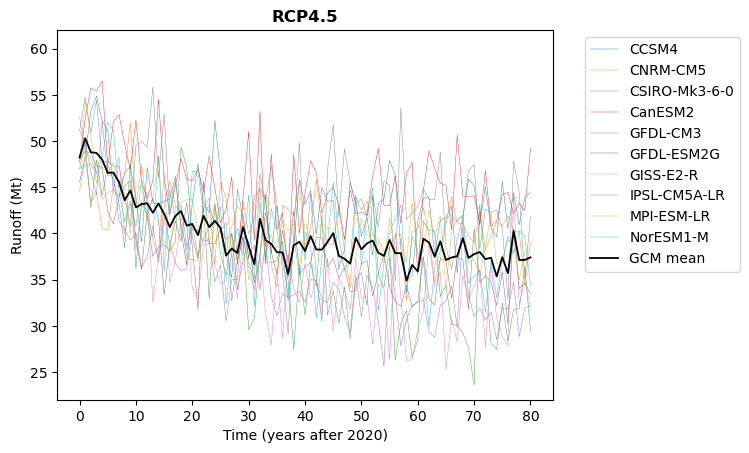

In [17]:
fig, ax = plt.subplots()
for k in rcp45_dict.keys():
    to_plot = rcp45_dict[k]
    ax.plot(to_plot, linewidth=0.3, label=k)
ax.plot(rcp45_df['mean'], color='k', label='GCM mean', linewidth=1.3);
plt.legend(bbox_to_anchor=(1.05, 1));
plt.xlabel('Time (years after 2020)');
plt.ylabel('Runoff (Mt)');
plt.ylim([22,62]);
plt.title('RCP4.5', fontweight='bold');

#plt.savefig('Figures/Annual/rcp45_mean_runoff_wGCMs.png', bbox_inches='tight')

## RCP 6.0 figure w/mean

In [18]:
# Make a dictionary for rcp60 values
rcp60_dict = {}

gcm_list = ['CCSM4', 'CSIRO-Mk3-6-0', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'NorESM1-M']
date_list = ['2023-01-12', '2023-01-17', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-25', '2023-01-25']

base = '~/Documents/Molly-thesis/Data/'
rcp='rcp60'

x=0

for gcm in gcm_list:
    rcp60_values = make_summed_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
    k = '{}'.format(gcm)
    rcp60_dict[k]=rcp60_values
    x += 1

In [19]:
rcp60_df = pd.DataFrame(rcp60_dict)

rcp60_df['mean'] = rcp60_df.transpose().mean()
#rcp_mean = rcp26_df.transpose().rolling(window=4).mean()

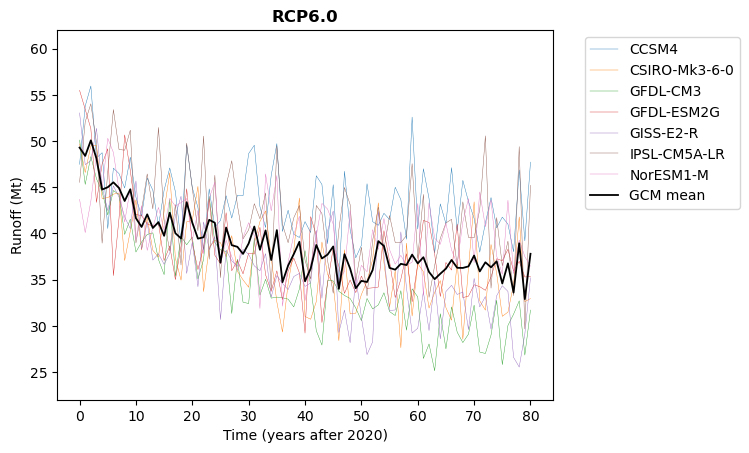

In [188]:
fig, ax = plt.subplots()
for k in rcp60_dict.keys():
    to_plot = rcp60_dict[k]
    ax.plot(to_plot, linewidth=0.3, label=k)
ax.plot(rcp60_df['mean'], color='k', label='GCM mean', linewidth=1.3);
plt.legend(bbox_to_anchor=(1.05, 1));
plt.xlabel('Time (years after 2020)');
plt.ylabel('Runoff (Mt)');
plt.ylim([22,62]);
plt.title('RCP6.0', fontweight='bold');

#plt.savefig('Figures/Annual/rcp60_mean_runoff_wGCMs.png', bbox_inches='tight')

## RCP 8.5 figure w/mean

In [21]:
# Make a dictionary for rcp8# Make a dictionary for rcp45 values
rcp85_dict = {}

gcm_list = ['CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'MPI-ESM-LR', 'NorESM1-M']
date_list = ['2023-01-12', '2023-01-23', '2023-01-17', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-25', '2023-01-25', '2023-01-25']

base = '~/Documents/Molly-thesis/Data/'
rcp='rcp85'

x=0

for gcm in gcm_list:
    rcp85_values = make_summed_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
    k = '{}'.format(gcm)
    rcp85_dict[k]=rcp85_values
    x += 1
rcp85_dict = {}

gcm_list = ['CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'MPI-ESM-LR', 'NorESM1-M']
date_list = ['2023-01-12', '2023-01-23', '2023-01-17', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-25', '2023-01-25', '2023-01-25']

base = '~/Documents/Molly-thesis/Data/'
rcp='rcp85'

x=0

for gcm in gcm_list:
    rcp85_values = make_summed_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
    k = '{}'.format(gcm)
    rcp85_dict[k]=rcp85_values
    x += 1

In [22]:
rcp85_df = pd.DataFrame(rcp85_dict)

rcp85_df['mean'] = rcp85_df.transpose().mean()
#rcp_mean = rcp26_df.transpose().rolling(window=4).mean()

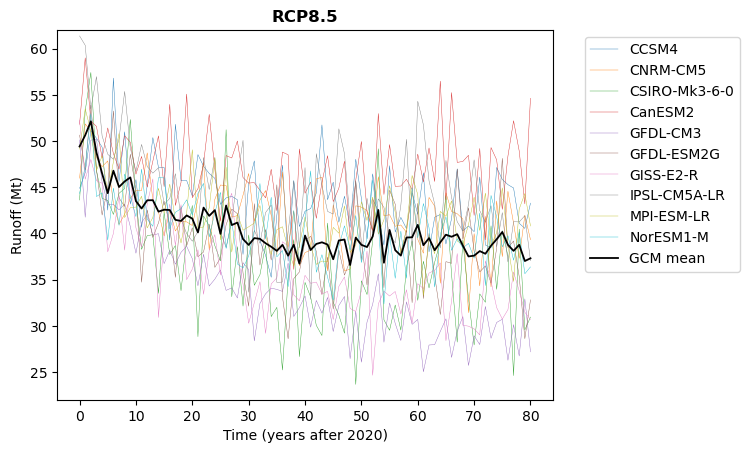

In [189]:
fig, ax = plt.subplots()
for k in rcp85_dict.keys():
    to_plot = rcp85_dict[k]
    ax.plot(to_plot, linewidth=0.3, label=k)
ax.plot(rcp85_df['mean'], color='k', label='GCM mean', linewidth=1.3);
plt.legend(bbox_to_anchor=(1.05, 1));
plt.xlabel('Time (years after 2020)');
plt.ylabel('Runoff (Mt)');
plt.ylim([22,62]);
plt.title('RCP8.5', fontweight='bold');

plt.savefig('Figures/Annual/rcp85_mean_runoff_wGCMs.png', bbox_inches='tight')

## Combine all runoff plots into one:

This runoff plot is not updated with axes!

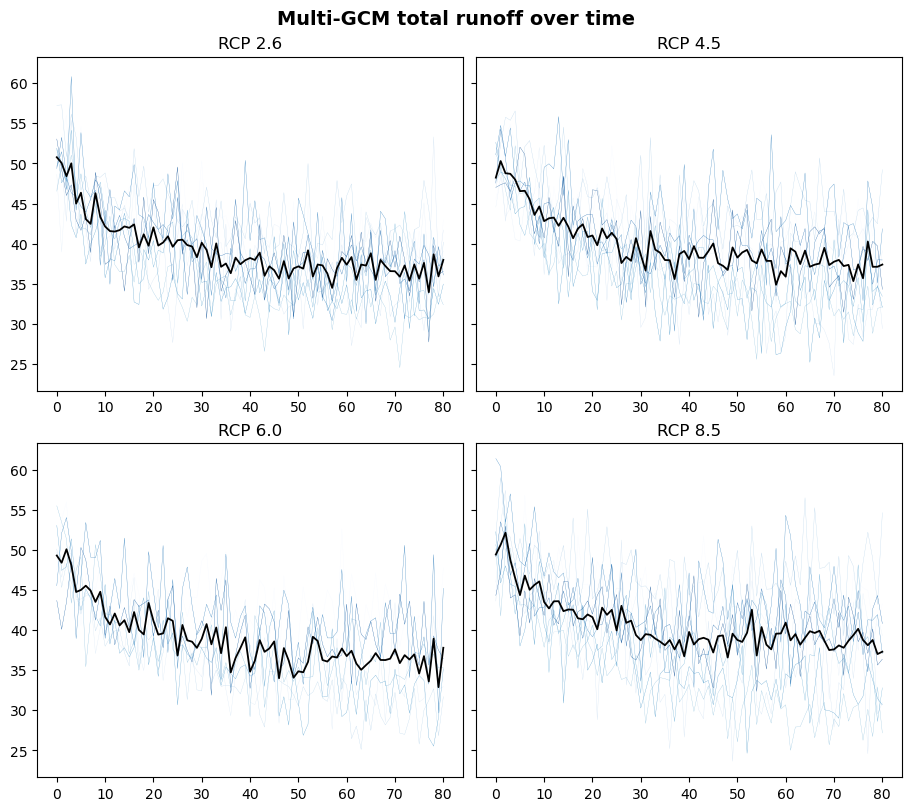

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 8), sharey=True, constrained_layout = True)

from matplotlib import cm
color_runoff = cm.get_cmap('Blues')

for i,k in enumerate(rcp26_dict.keys()):
    color_idx = i/len(rcp26_dict.keys())
    to_plot = rcp26_dict[k]
    toplot_df = pd.DataFrame(to_plot)
    toplot_df.plot(ax = ax1, linewidth=0.2, label='', color=color_runoff(color_idx))
for i,k in enumerate(rcp45_dict.keys()):
    color_idx = i/len(rcp45_dict.keys())
    to_plot = rcp45_dict[k]
    toplot_df = pd.DataFrame(to_plot)
    toplot_df.plot(ax = ax2, linewidth=0.2, label='', color=color_runoff(color_idx))  
for i,k in enumerate(rcp60_dict.keys()):
    color_idx = i/len(rcp60_dict.keys())
    to_plot = rcp60_dict[k]
    toplot_df = pd.DataFrame(to_plot)
    toplot_df.plot(ax = ax3, linewidth=0.2, label='', color=color_runoff(color_idx))
for i,k in enumerate(rcp85_dict.keys()):
    color_idx = i/len(rcp85_dict.keys())
    to_plot = rcp85_dict[k]
    toplot_df = pd.DataFrame(to_plot)
    toplot_df.plot(ax = ax4, linewidth=0.2, label='', color=color_runoff(color_idx))
ax1.plot(rcp26_df['mean'], color='k', linewidth=1.3);
ax2.plot(rcp45_df['mean'], color='k', linewidth=1.3);
ax3.plot(rcp60_df['mean'], color='k', linewidth=1.3);
ax4.plot(rcp85_df['mean'], color='k', linewidth=1.3);

ax1.set(title='RCP 2.6')
ax2.set(title='RCP 4.5')
ax3.set(title='RCP 6.0')
ax4.set(title='RCP 8.5');
# for ax in (ax1,ax2,ax3,ax4):
#     ax.set(xlabel = 'Time [yrs]'
#           );

ax1.legend('', frameon=False)
ax2.legend('', frameon=False)
ax3.legend('', frameon=False)
ax4.legend('', frameon=False)

plt.suptitle("Multi-GCM total runoff over time", fontweight='bold', fontsize=14);

#plt.savefig('Figures/Annual/total_runoff_4_2.png', bbox_inches='tight')

This plot IS updated with axes! Use this one!!

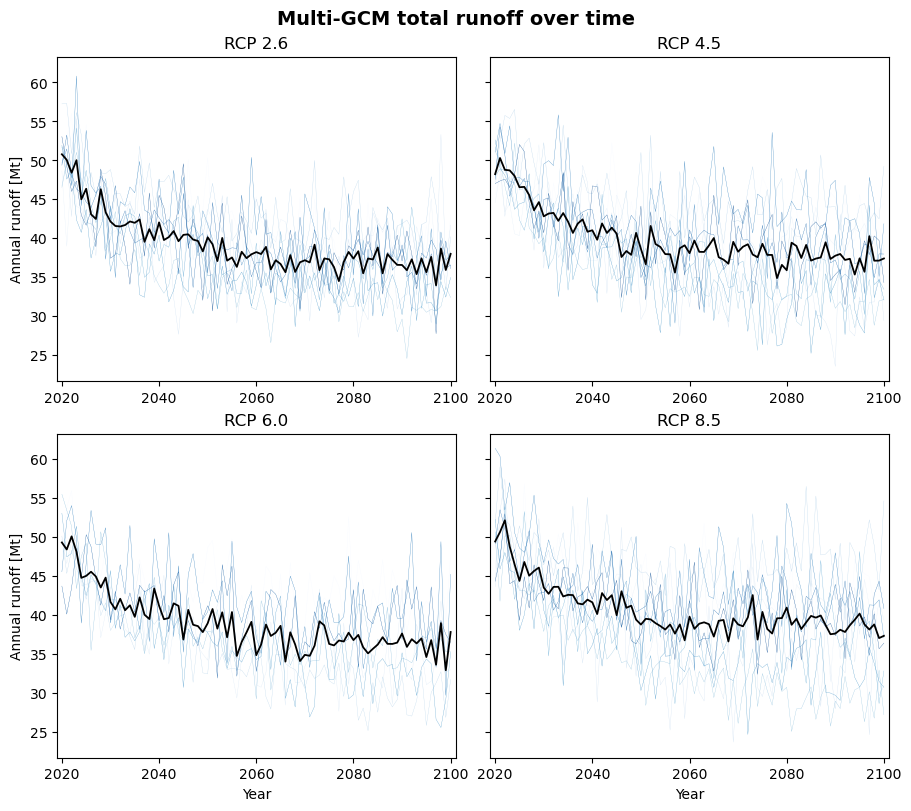

In [316]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 8), sharey=True, constrained_layout = True)

from matplotlib import cm
color_runoff = cm.get_cmap('Blues')

#years_toplot = toplot_df.index + 2020

for i,k in enumerate(rcp26_dict.keys()):
    color_idx = i/len(rcp26_dict.keys())
    to_plot = rcp26_dict[k]
    toplot_df = pd.DataFrame(to_plot)
    years_toplot = toplot_df.index + 2020
    ax1.plot(years_toplot, toplot_df.values, linewidth=0.2, label='', color=color_runoff(color_idx))
for i,k in enumerate(rcp45_dict.keys()):
    color_idx = i/len(rcp45_dict.keys())
    to_plot = rcp45_dict[k]
    toplot_df = pd.DataFrame(to_plot)
    ax2.plot(years_toplot, toplot_df.values, linewidth=0.2, label='', color=color_runoff(color_idx))  
for i,k in enumerate(rcp60_dict.keys()):
    color_idx = i/len(rcp60_dict.keys())
    to_plot = rcp60_dict[k]
    toplot_df = pd.DataFrame(to_plot)
    ax3.plot(years_toplot, toplot_df.values, linewidth=0.2, label='', color=color_runoff(color_idx))  
for i,k in enumerate(rcp85_dict.keys()):
    color_idx = i/len(rcp85_dict.keys())
    to_plot = rcp85_dict[k]
    toplot_df = pd.DataFrame(to_plot)
    ax4.plot(years_toplot, toplot_df.values, linewidth=0.2, label='', color=color_runoff(color_idx))  
ax1.plot(years_toplot, rcp26_df['mean'].values, color='k', linewidth=1.3);
ax2.plot(years_toplot, rcp45_df['mean'].values, color='k', linewidth=1.3);
ax3.plot(years_toplot, rcp60_df['mean'].values, color='k', linewidth=1.3);
ax4.plot(years_toplot, rcp85_df['mean'].values, color='k', linewidth=1.3);

ax1.set(#xlabel = 'Year', 
        ylabel = "Annual runoff [Mt]", 
        title='RCP 2.6',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2019,2101))
ax2.set(#xlabel = 'Year', 
        #ylabel = "Annual runoff [Mt]", 
        title='RCP 4.5',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2019,2101))
ax3.set(xlabel = 'Year', 
        ylabel = "Annual runoff [Mt]", 
        title='RCP 6.0',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2019,2101))
ax4.set(xlabel = 'Year', 
        #ylabel = "Annual runoff [Mt]", 
        title='RCP 8.5',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2019,2101))

ax1.legend('', frameon=False)
ax2.legend('', frameon=False)
ax3.legend('', frameon=False)
ax4.legend('', frameon=False)

plt.suptitle("Multi-GCM total runoff over time", fontweight='bold', fontsize=14);

#plt.savefig('Figures/Annual/total_runoff_may4.png', bbox_inches='tight')

<b> A plot of all means for rcps without underlying gcms:

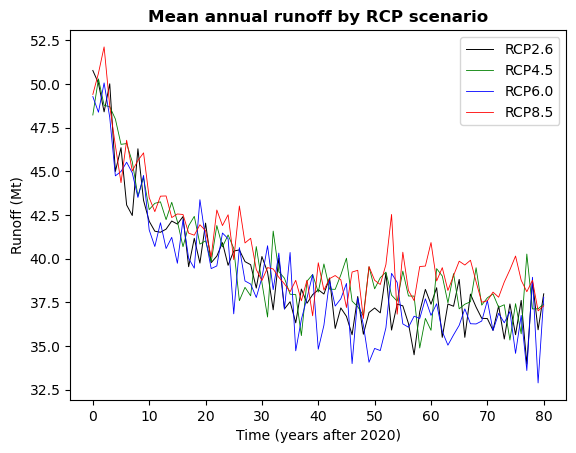

In [182]:
fig, ax = plt.subplots()
ax.plot(rcp26_df['mean'], color='k', label='RCP2.6', linewidth=0.7);
ax.plot(rcp45_df['mean'], color='g', label='RCP4.5', linewidth=0.6);
ax.plot(rcp60_df['mean'], color='b', label='RCP6.0', linewidth=0.6);
ax.plot(rcp85_df['mean'], color='r', label='RCP8.5', linewidth=0.6);
plt.legend();
plt.xlabel('Time (years after 2020)');
plt.ylabel('Runoff (Mt)');
plt.title('Mean annual runoff by RCP scenario', fontweight='bold');

#plt.savefig('Figures/Annual/mean_runoff_all_rcps.png', bbox_inches='tight')

## Other (outdated runoff plots without means)

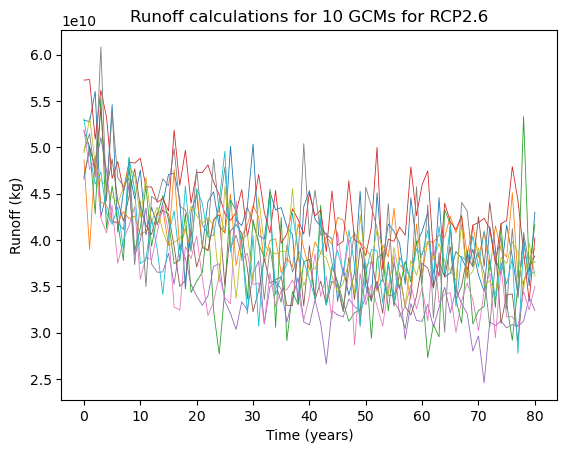

In [31]:
fig, ax = plt.subplots()
for k in rcp26_dict.keys():
     to_plot = rcp26_dict[k]
     ax.plot(to_plot, linewidth=0.6)
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
plt.title('Runoff calculations for 10 GCMs for RCP2.6')

#plt.savefig('10gcms_rcp26.png')

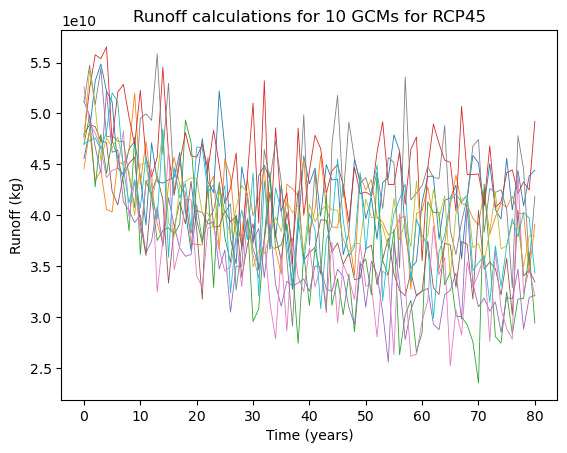

In [32]:
fig, ax = plt.subplots()
for k in rcp45_dict.keys():
     to_plot = rcp45_dict[k]
     ax.plot(to_plot, linewidth=0.6)
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
plt.title('Runoff calculations for 10 GCMs for RCP45')

#plt.savefig('10gcms_rcp45.png')

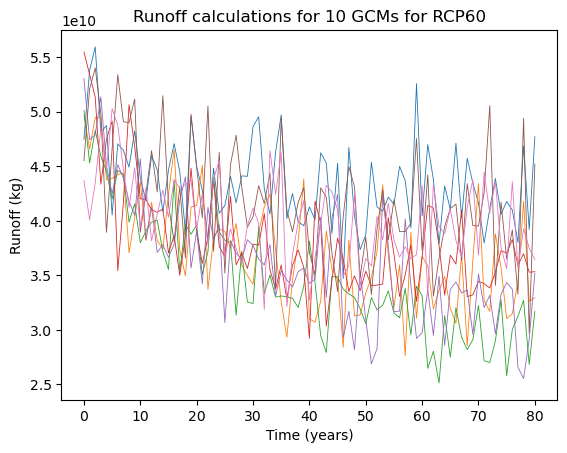

In [34]:
fig, ax = plt.subplots()
for k in rcp60_dict.keys():
     to_plot = rcp60_dict[k]
     ax.plot(to_plot, linewidth=0.6)
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
plt.title('Runoff calculations for 10 GCMs for RCP60')

#plt.savefig('10gcms_rcp60.png')

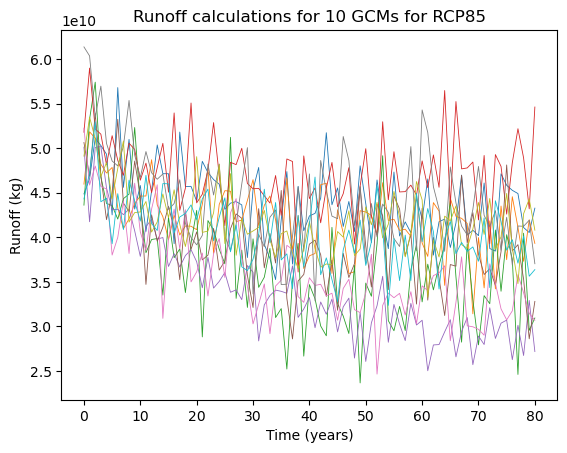

In [36]:
fig, ax = plt.subplots()
for k in rcp85_dict.keys():
     to_plot = rcp85_dict[k]
     ax.plot(to_plot, linewidth=0.6)
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
plt.title('Runoff calculations for 10 GCMs for RCP85')

#plt.savefig('10gcms_rcp85.png')

# <b> Visualizing runoff types

### FUNCTIONS

In [14]:
# Make a series with different runoff stems
def make_series(runoff_stem, fpath_stem, which_date, which_gcm, which_rcp):
    this_fpath = fpath_stem+'{}-gcm_data_{}_{}_compiled_output.nc'.format(which_date, which_gcm, which_rcp)
    this_ds = xr.open_dataset(this_fpath)
    this_ds_runoff = this_ds[runoff_stem]
    this_runoff = this_ds_runoff.sum(dim='rgi_id').dropna(dim='time')
    nonzero_sum = this_runoff.where(this_runoff!=0, drop=True)
    nonzero_sum *= 1e-9
    return nonzero_sum

In [15]:
# Make a dictionary for each runoff type
def to_dict(gcm_list, runoff_stem, fpath_stem, which_date, which_rcp):
    x=0
    dictionary = {}
    for gcm in gcm_list:
        rcp_values = make_series(runoff_stem, fpath_stem, which_date[x], which_gcm=gcm, which_rcp=rcp)
        k = '{}'.format(gcm)
        dictionary[k]=rcp_values
        x += 1
    return dictionary

In [321]:
# Turn each runoff type into a dataframe and find the mean
def to_df(dataframe):
    my_df = pd.DataFrame(dataframe)
    my_df['mean'] = my_df.transpose().mean(axis=0)
    return my_df

## Find runoff quantities for rcp2.6

In [370]:
gcm_list = ['CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'MPI-ESM-LR', 'NorESM1-M']
date_list = ['2023-01-12', '2023-01-23', '2023-01-17', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-25', '2023-01-25', '2023-01-25']
base = '~/Documents/Molly-thesis/Data/'
rcp='rcp26'

runoff = 'melt_on_glacier'
rcp26_melt_on = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

runoff = 'melt_off_glacier'
rcp26_melt_off = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

runoff = 'liq_prcp_on_glacier'
rcp26_liq_on = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

runoff = 'liq_prcp_off_glacier'
rcp26_liq_off = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

In [16]:
rcp26_liq_off

{'CCSM4': <xarray.DataArray 'liq_prcp_off_glacier' (time: 81)>
 array([17.24999 , 18.063688, 20.128855, 16.704672, 19.339386, 23.065937,
        18.018583, 22.652594, 25.245646, 23.146069, 25.509472, 22.401955,
        25.328129, 24.736782, 26.513905, 28.893715, 28.269611, 27.307104,
        21.319288, 27.411846, 27.898191, 25.050138, 29.419987, 30.253399,
        27.474787, 27.120361, 34.67224 , 28.295187, 28.342758, 30.34625 ,
        36.24092 , 28.98514 , 28.77472 , 32.87769 , 31.908575, 32.443516,
        30.64743 , 30.07176 , 23.858385, 33.085175, 34.6759  , 32.61457 ,
        32.0499  , 31.215845, 30.696985, 25.3903  , 28.212173, 25.559746,
        26.309072, 35.014095, 26.583591, 24.699024, 34.71796 , 28.948149,
        31.824005, 31.232656, 30.88973 , 26.374338, 34.22173 , 30.87785 ,
        31.738152, 32.911163, 26.534754, 34.94522 , 27.425503, 27.89635 ,
        29.860357, 29.07598 , 28.80064 , 30.601877, 27.83267 , 24.477365,
        31.459478, 29.055601, 28.632313, 32.96363

In [382]:
rcp26_melt_on_df = to_df(rcp26_melt_on)
rcp26_melt_off_df = to_df(rcp26_melt_off)
rcp26_liq_on_df = to_df(rcp26_liq_on)
rcp26_liq_off_df = to_df(rcp26_liq_off)

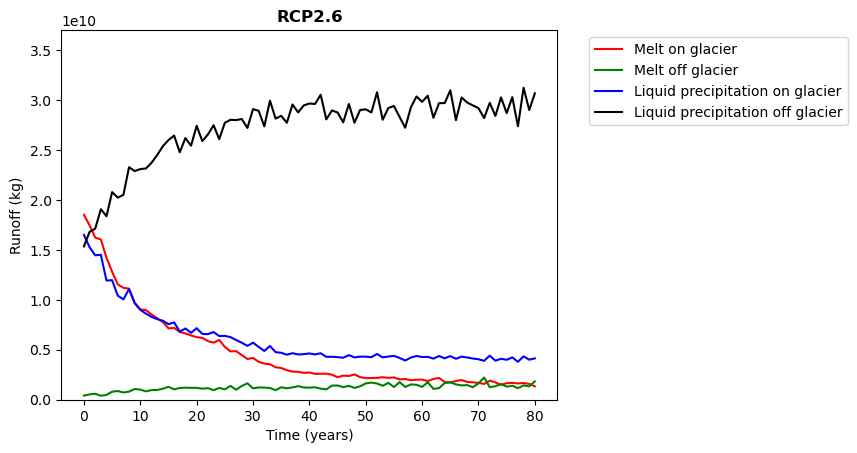

In [122]:
fig, ax = plt.subplots()
rcp26_melt_on_df['mean'].plot(ax=ax, color='r', label='Melt on glacier')
rcp26_melt_off_df['mean'].plot(ax=ax, color='g', label='Melt off glacier')
rcp26_liq_on_df['mean'].plot(ax=ax, color='b', label='Liquid precipitation on glacier')
rcp26_liq_off_df['mean'].plot(ax=ax, color='k', label='Liquid precipitation off glacier')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
plt.ylim([0,37000000000])
plt.title('RCP2.6', fontweight='bold')

#plt.savefig('rcp26_runoff_types.png', bbox_inches='tight')

## Find runoff quantities for rcp4.5

In [371]:
gcm_list = ['CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'MPI-ESM-LR', 'NorESM1-M']
date_list = ['2023-01-12', '2023-01-23', '2023-01-17', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-25', '2023-01-25', '2023-01-25']
base = '~/Documents/Molly-thesis/Data/'
rcp='rcp45'

runoff = 'melt_on_glacier'
rcp45_melt_on = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

runoff = 'melt_off_glacier'
rcp45_melt_off = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

runoff = 'liq_prcp_on_glacier'
rcp45_liq_on = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

runoff = 'liq_prcp_off_glacier'
rcp45_liq_off = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

In [383]:
rcp45_melt_on_df = to_df(rcp45_melt_on)
rcp45_melt_off_df = to_df(rcp45_melt_off)
rcp45_liq_on_df = to_df(rcp45_liq_on)
rcp45_liq_off_df = to_df(rcp45_liq_off)

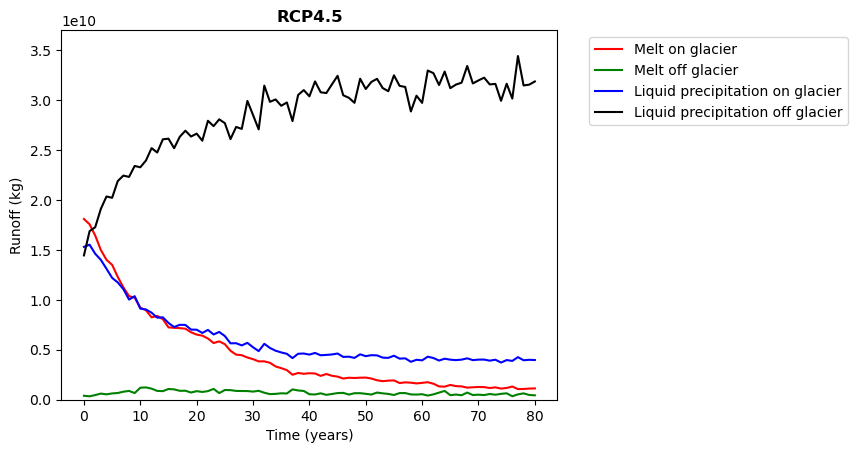

In [123]:
fig, ax = plt.subplots()
rcp45_melt_on_df['mean'].plot(ax=ax, color='r', label='Melt on glacier')
rcp45_melt_off_df['mean'].plot(ax=ax, color='g', label='Melt off glacier')
rcp45_liq_on_df['mean'].plot(ax=ax, color='b', label='Liquid precipitation on glacier')
rcp45_liq_off_df['mean'].plot(ax=ax, color='k', label='Liquid precipitation off glacier')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
plt.ylim([0,37000000000])
plt.title('RCP4.5', fontweight='bold')

#plt.savefig('rcp45_runoff_types.png', bbox_inches='tight')

## Find runoff quantities for rcp6.0

In [372]:
gcm_list = ['CCSM4', 'CSIRO-Mk3-6-0', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'NorESM1-M']
date_list = ['2023-01-12', '2023-01-17', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-25', '2023-01-25']
base = '~/Documents/Molly-thesis/Data/'
rcp='rcp60'

runoff = 'melt_on_glacier'
rcp60_melt_on = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

runoff = 'melt_off_glacier'
rcp60_melt_off = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

runoff = 'liq_prcp_on_glacier'
rcp60_liq_on = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

runoff = 'liq_prcp_off_glacier'
rcp60_liq_off = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

In [384]:
rcp60_melt_on_df = to_df(rcp60_melt_on)
rcp60_melt_off_df = to_df(rcp60_melt_off)
rcp60_liq_on_df = to_df(rcp60_liq_on)
rcp60_liq_off_df = to_df(rcp60_liq_off)

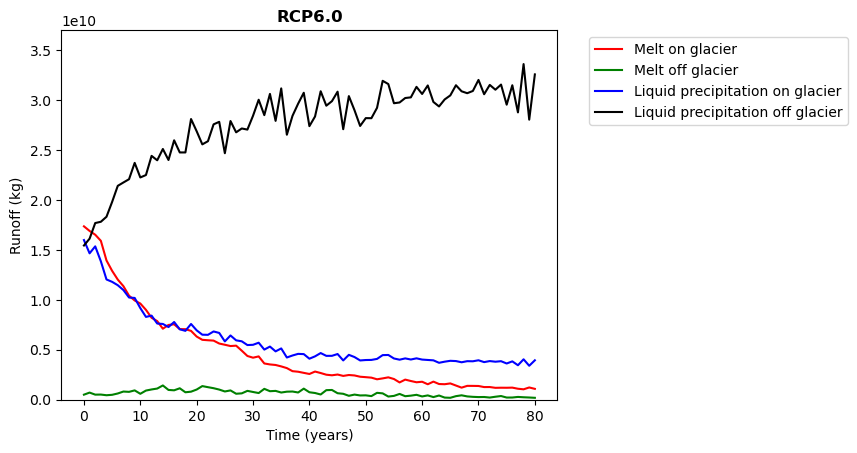

In [124]:
fig, ax = plt.subplots()
rcp60_melt_on_df['mean'].plot(ax=ax, color='r', label='Melt on glacier')
rcp60_melt_off_df['mean'].plot(ax=ax, color='g', label='Melt off glacier')
rcp60_liq_on_df['mean'].plot(ax=ax, color='b', label='Liquid precipitation on glacier')
rcp60_liq_off_df['mean'].plot(ax=ax, color='k', label='Liquid precipitation off glacier')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
plt.ylim([0,37000000000])
plt.title('RCP6.0', fontweight='bold')

#plt.savefig('rcp60_runoff_types.png', bbox_inches='tight')

## Find runoff quantities for rcp8.5

In [373]:
gcm_list = ['CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'MPI-ESM-LR', 'NorESM1-M']
date_list = ['2023-01-12', '2023-01-23', '2023-01-17', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-25', '2023-01-25', '2023-01-25']
base = '~/Documents/Molly-thesis/Data/'
rcp='rcp85'

runoff = 'melt_on_glacier'
rcp85_melt_on = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

runoff = 'melt_off_glacier'
rcp85_melt_off = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

runoff = 'liq_prcp_on_glacier'
rcp85_liq_on = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

runoff = 'liq_prcp_off_glacier'
rcp85_liq_off = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

In [385]:
rcp85_melt_on_df = to_df(rcp85_melt_on)
rcp85_melt_off_df = to_df(rcp85_melt_off)
rcp85_liq_on_df = to_df(rcp85_liq_on)
rcp85_liq_off_df = to_df(rcp85_liq_off)

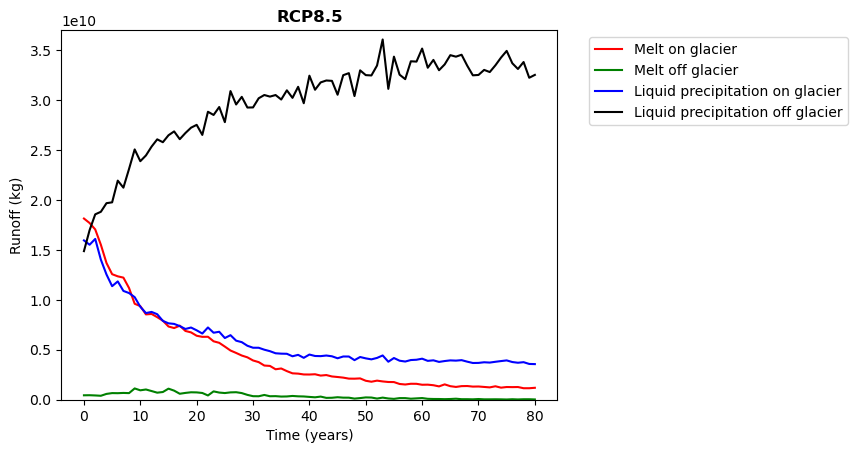

In [125]:
fig, ax = plt.subplots()
rcp85_melt_on_df['mean'].plot(ax=ax, color='r', label='Melt on glacier')
rcp85_melt_off_df['mean'].plot(ax=ax, color='g', label='Melt off glacier')
rcp85_liq_on_df['mean'].plot(ax=ax, color='b', label='Liquid precipitation on glacier')
rcp85_liq_off_df['mean'].plot(ax=ax, color='k', label='Liquid precipitation off glacier')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
plt.ylim([0,37000000000])
plt.title('RCP8.5', fontweight='bold')

#plt.savefig('rcp85_runoff_types.png', bbox_inches='tight')

# <b> Combined runoff types plots for each rcp scenario

In [35]:
# Add runoff types together
rcp26_melt = (rcp26_melt_on_df + rcp26_melt_off_df)
rcp26_prcp = (rcp26_liq_on_df + rcp26_liq_off_df)
rcp45_melt = (rcp45_melt_on_df + rcp45_melt_off_df)
rcp45_prcp = (rcp45_liq_on_df + rcp26_liq_off_df)
rcp60_melt = (rcp60_melt_on_df + rcp60_melt_off_df)
rcp60_prcp = (rcp60_liq_on_df + rcp60_liq_off_df)
rcp85_melt = (rcp85_melt_on_df + rcp85_melt_off_df)
rcp85_prcp = (rcp85_liq_on_df + rcp85_liq_off_df)

In [106]:
# Do the same thing as above but with diff categories for glacier melt
rcp26_melt_on = rcp26_melt_on_df
rcp26_melt_off = rcp26_melt_off_df
rcp26_prcp = (rcp26_liq_on_df + rcp26_liq_off_df)

rcp45_melt_on = rcp45_melt_on_df
rcp45_melt_off = rcp45_melt_off_df
rcp45_prcp = (rcp45_liq_on_df + rcp26_liq_off_df)

rcp60_melt_on = rcp60_melt_on_df
rcp60_melt_off = rcp60_melt_off_df
rcp60_prcp = (rcp60_liq_on_df + rcp60_liq_off_df)

rcp85_melt_on = rcp85_melt_on_df
rcp85_melt_off = rcp85_melt_off_df
rcp85_prcp = (rcp85_liq_on_df + rcp85_liq_off_df)

Text(0.5, 1.0, 'RCP2.6')

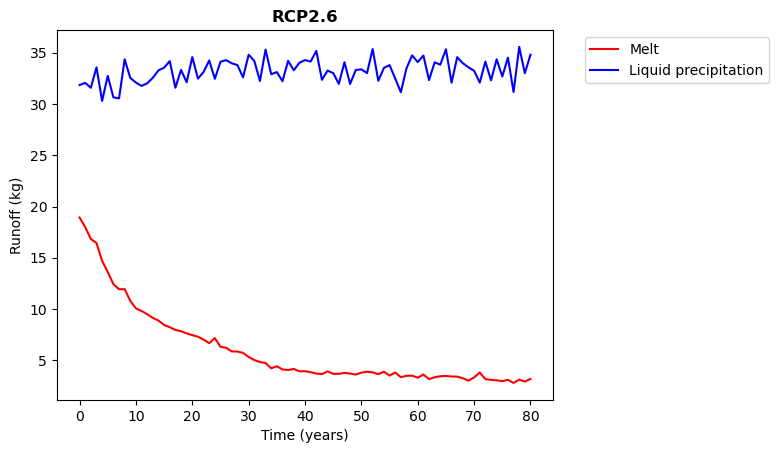

In [27]:
fig, ax = plt.subplots()
rcp26_melt['mean'].plot(ax=ax, color='r', label='Melt')
rcp26_prcp['mean'].plot(ax=ax, color='b', label='Liquid precipitation')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('Time (years)')
plt.ylabel('Runoff (kg)')
#plt.ylim([0,37000000000])
plt.title('RCP2.6', fontweight='bold')

#plt.savefig('rcp26_runoff_types.png', bbox_inches='tight')

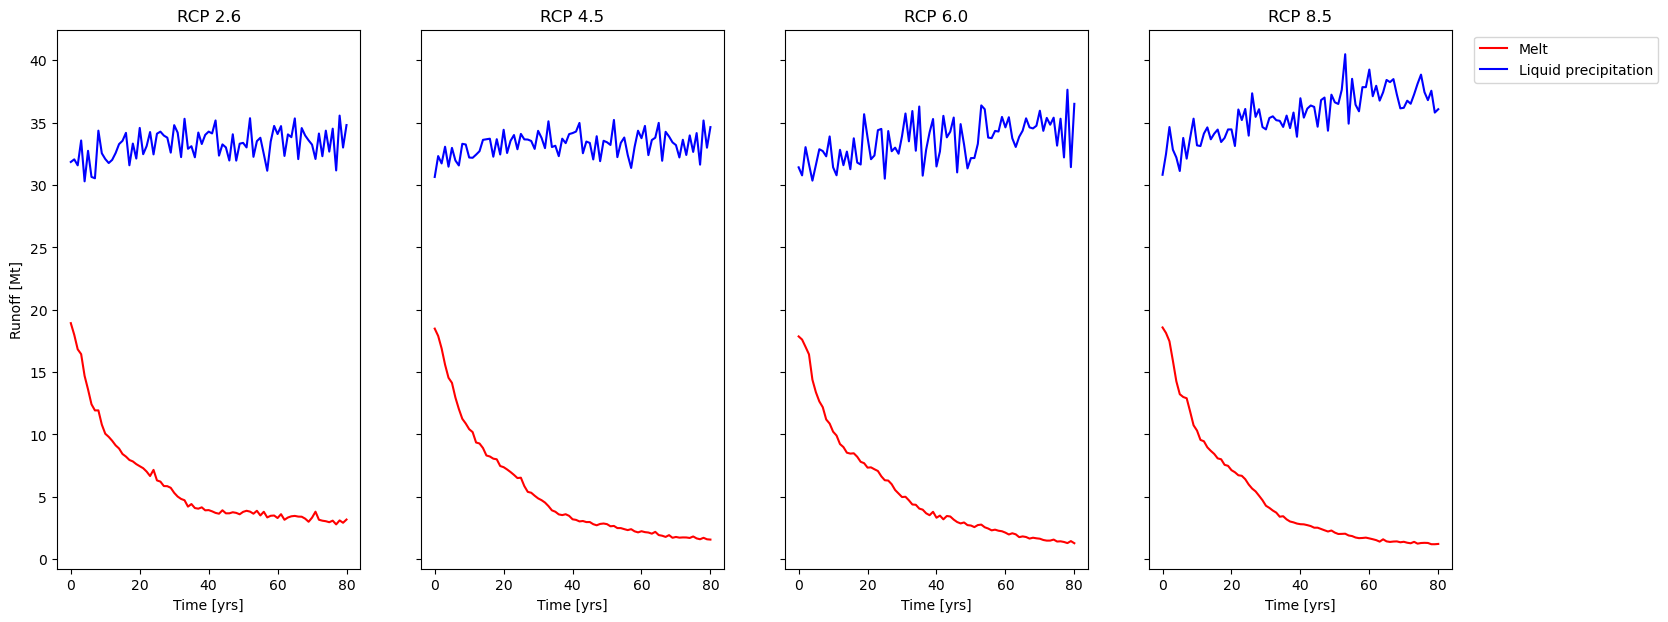

In [45]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 7), sharey=True)
rcp26_melt['mean'].plot(ax=ax1, color='r', label='Melt')
rcp26_prcp['mean'].plot(ax=ax1, color='b', label='Liquid precipitation')
rcp45_melt['mean'].plot(ax=ax2, color='r', label='Melt')
rcp45_prcp['mean'].plot(ax=ax2, color='b', label='Liquid precipitation')
rcp60_melt['mean'].plot(ax=ax3, color='r', label='Melt')
rcp60_prcp['mean'].plot(ax=ax3, color='b', label='Liquid precipitation')
rcp85_melt['mean'].plot(ax=ax4, color='r', label='Melt')
rcp85_prcp['mean'].plot(ax=ax4, color='b', label='Liquid precipitation')
ax1.set(ylabel='Runoff [Mt]', xlabel='Time [yrs]', title='RCP 2.6')
ax2.set(title='RCP 4.5', xlabel='Time [yrs]',)
ax3.set(title='RCP 6.0', xlabel='Time [yrs]',)
ax4.set(title='RCP 8.5', xlabel='Time [yrs]',)

plt.legend(bbox_to_anchor=(1.05, 1));
#plt.xlabel('Time (years)')
#plt.ylabel('Runoff (kg)')
#plt.ylim([0,37000000000])
#plt.title('o')

In [357]:
# Look at one runoff type (melt)
columns = ['CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'MPI-ESM-LR', 'NorESM1-M']
columns_60 = ['CCSM4', 'CSIRO-Mk3-6-0', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'NorESM1-M']

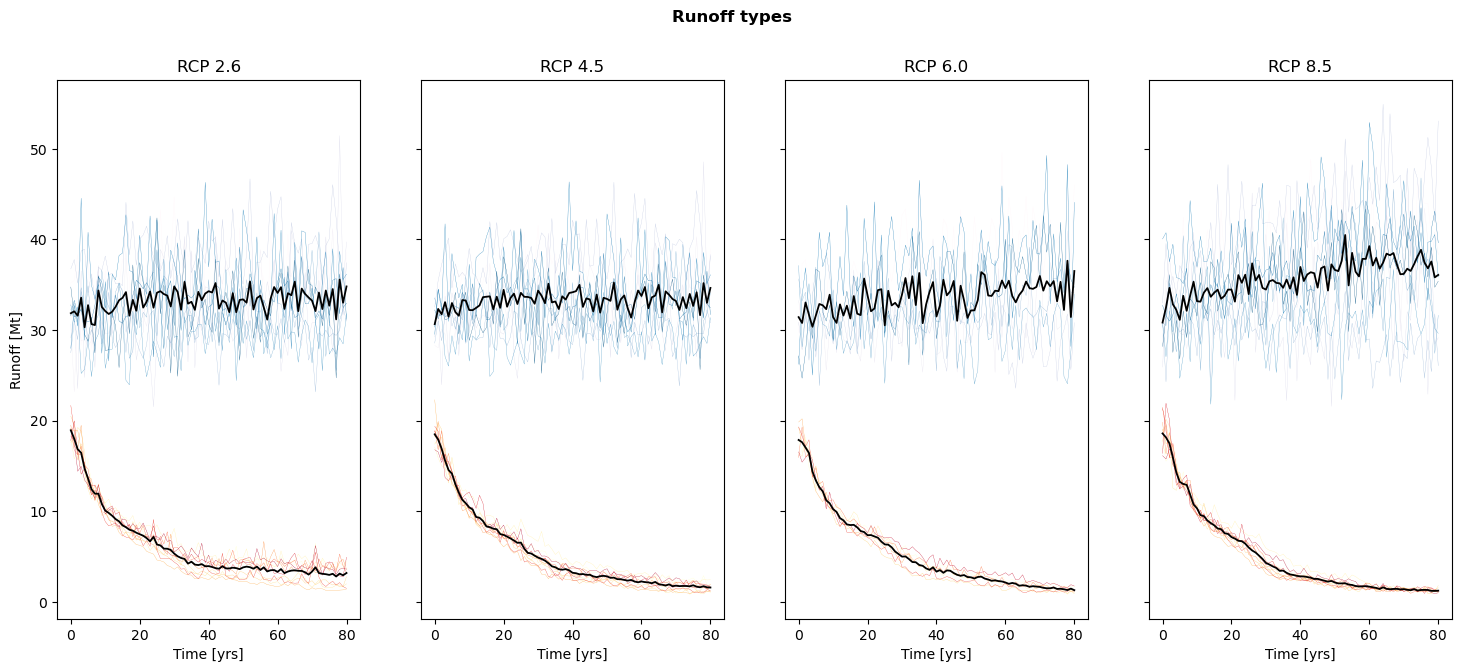

In [267]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 7), sharey=True)

from matplotlib import cm
colorz = cm.get_cmap('PuBu')
colorz2 = cm.get_cmap('YlOrRd')

# for c in columns:
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt = rcp26_melt[c]
    to_plot_melt.plot(ax=ax1, linewidth=0.2, label=c, color=colorz2(color_idx))
    to_plot_prcp = rcp26_prcp[c]
    to_plot_prcp.plot(ax=ax1, linewidth=0.2, color=colorz(color_idx))
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt = rcp45_melt[c]
    to_plot_melt.plot(ax=ax2, linewidth=0.2, color=colorz2(color_idx))
    to_plot_prcp = rcp45_prcp[c]
    to_plot_prcp.plot(ax=ax2, linewidth=0.2, color=colorz(color_idx))
for i,c in enumerate(columns_60):
    color_idx = i/len(columns_60)
    to_plot_melt = rcp60_melt[c]
    to_plot_melt.plot(ax=ax3, linewidth=0.2, color=colorz2(color_idx))
    to_plot_prcp = rcp60_prcp[c]
    to_plot_prcp.plot(ax=ax3, linewidth=0.2, color=colorz(color_idx))
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt = rcp85_melt[c]
    to_plot_melt.plot(ax=ax4, linewidth=0.2, color=colorz2(color_idx))
    to_plot_prcp = rcp85_prcp[c]
    to_plot_prcp.plot(ax=ax4, linewidth=0.2, color=colorz(color_idx))
rcp26_melt['mean'].plot(ax=ax1, color='k', label='GCM mean', linewidth=1.3);
rcp26_prcp['mean'].plot(ax=ax1, color='k', label='GCM mean', linewidth=1.3);
rcp45_melt['mean'].plot(ax=ax2, color='k', label='GCM mean', linewidth=1.3);
rcp45_prcp['mean'].plot(ax=ax2, color='k', label='GCM mean', linewidth=1.3);
rcp60_melt['mean'].plot(ax=ax3, color='k', label='', linewidth=1.3);
rcp60_prcp['mean'].plot(ax=ax3, color='k', label='', linewidth=1.3);
rcp85_melt['mean'].plot(ax=ax4, color='k', label='GCM mean', linewidth=1.3);
rcp85_prcp['mean'].plot(ax=ax4, color='k', label='GCM mean', linewidth=1.3);
#plt.legend(bbox_to_anchor=(1.05, 1))
ax1.set(ylabel='Runoff [Mt]', title='RCP 2.6')
ax2.set(title='RCP 4.5')
ax3.set(title='RCP 6.0')
ax4.set(title='RCP 8.5');
for ax in (ax1,ax2,ax3,ax4):
    ax.set(xlabel = 'Time [yrs]'
          );
plt.suptitle("Runoff types", fontweight='bold');

#plt.savefig('Figures/Annual/cumulative_annual_runoff.png', bbox_inches='tight')

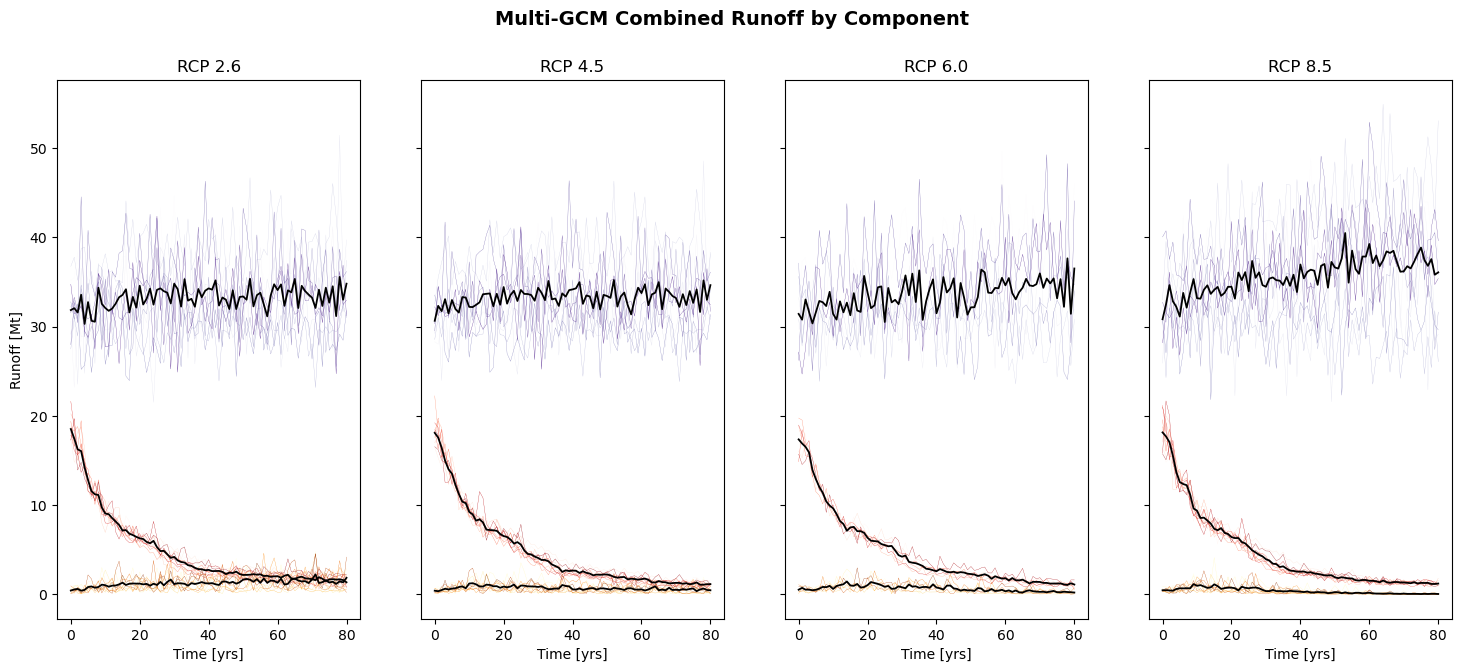

In [283]:
# Make the same figure as above but with diff runoff components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 7), sharey=True)

from matplotlib import cm
colorz = cm.get_cmap('Purples')
colorz2 = cm.get_cmap('Reds')
colorz3 = cm.get_cmap('YlOrBr')

# for c in columns:
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_on = rcp26_melt_on[c]
    to_plot_melt_on.plot(ax=ax1, linewidth=0.2, label=c, color=colorz2(color_idx))
    to_plot_melt_off = rcp26_melt_off[c]
    to_plot_melt_off.plot(ax=ax1, linewidth=0.2, label=c, color=colorz3(color_idx))
    to_plot_prcp = rcp26_prcp[c]
    to_plot_prcp.plot(ax=ax1, linewidth=0.2, color=colorz(color_idx))
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_on = rcp45_melt_on[c]
    to_plot_melt_on.plot(ax=ax2, linewidth=0.2, color=colorz2(color_idx))
    to_plot_melt_off = rcp45_melt_off[c]
    to_plot_melt_off.plot(ax=ax2, linewidth=0.2, color=colorz3(color_idx))
    to_plot_prcp = rcp45_prcp[c]
    to_plot_prcp.plot(ax=ax2, linewidth=0.2, color=colorz(color_idx))
for i,c in enumerate(columns_60):
    color_idx = i/len(columns_60)
    to_plot_melt_on = rcp60_melt_on[c]
    to_plot_melt_on.plot(ax=ax3, linewidth=0.2, color=colorz2(color_idx))
    to_plot_melt_off = rcp60_melt_off[c]
    to_plot_melt_off.plot(ax=ax3, linewidth=0.2, color=colorz3(color_idx))
    to_plot_prcp = rcp60_prcp[c]
    to_plot_prcp.plot(ax=ax3, linewidth=0.2, color=colorz(color_idx))
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_on = rcp85_melt_on[c]
    to_plot_melt_on.plot(ax=ax4, linewidth=0.2, color=colorz2(color_idx))
    to_plot_melt_off = rcp85_melt_off[c]
    to_plot_melt_off.plot(ax=ax4, linewidth=0.2, color=colorz3(color_idx))
    to_plot_prcp = rcp85_prcp[c]
    to_plot_prcp.plot(ax=ax4, linewidth=0.2, color=colorz(color_idx))
rcp26_melt_on['mean'].plot(ax=ax1, color='k', label='GCM mean', linewidth=1.3);
rcp26_melt_off['mean'].plot(ax=ax1, color='k', label='GCM mean', linewidth=1.3);
rcp26_prcp['mean'].plot(ax=ax1, color='k', label='GCM mean', linewidth=1.3);
rcp45_melt_on['mean'].plot(ax=ax2, color='k', label='GCM mean', linewidth=1.3);
rcp45_melt_off['mean'].plot(ax=ax2, color='k', label='GCM mean', linewidth=1.3);
rcp45_prcp['mean'].plot(ax=ax2, color='k', label='GCM mean', linewidth=1.3);
rcp60_melt_on['mean'].plot(ax=ax3, color='k', label='', linewidth=1.3);
rcp60_melt_off['mean'].plot(ax=ax3, color='k', label='', linewidth=1.3);
rcp60_prcp['mean'].plot(ax=ax3, color='k', label='', linewidth=1.3);
rcp85_melt_on['mean'].plot(ax=ax4, color='k', label='GCM mean', linewidth=1.3);
rcp85_melt_off['mean'].plot(ax=ax4, color='k', label='GCM mean', linewidth=1.3);
rcp85_prcp['mean'].plot(ax=ax4, color='k', label='GCM mean', linewidth=1.3);
#plt.legend(bbox_to_anchor=(1.05, 1))
ax1.set(ylabel='Runoff [Mt]', title='RCP 2.6')
ax2.set(title='RCP 4.5')
ax3.set(title='RCP 6.0')
ax4.set(title='RCP 8.5');
for ax in (ax1,ax2,ax3,ax4):
    ax.set(xlabel = 'Time [yrs]'
          );
plt.suptitle("Multi-GCM Combined Runoff by Component", fontweight='bold', fontsize=14);

#plt.xlabel('Time (years)')
#plt.ylabel('Runoff (kg)')
#plt.ylim([0,37000000000])
#plt.title('RCP2.6', fontweight='bold');

#plt.savefig('Figures/Annual/cumulative_annual_runoff_4_2_23.png', bbox_inches='tight')

### Make mega runoff plot with different sections for each runoff type

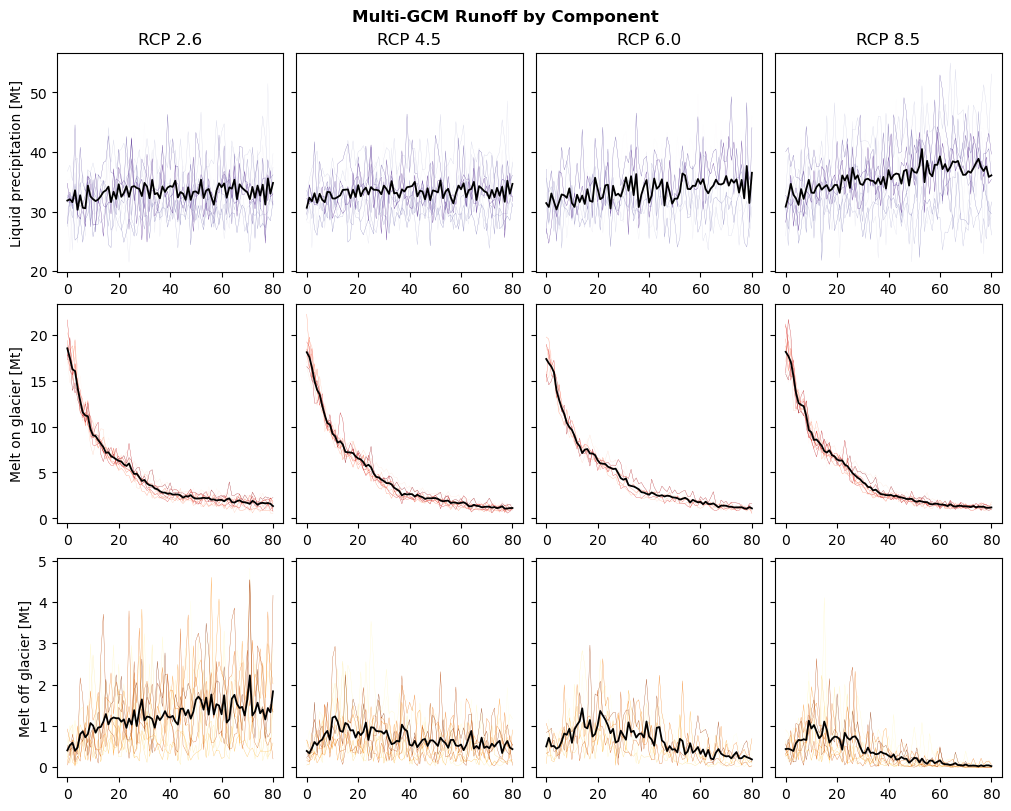

In [279]:
# Make the same figure as above but with diff runoff components
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3, 4, figsize=(10,8), sharey='row', constrained_layout=True)

from matplotlib import cm
colorz = cm.get_cmap('Purples')
colorz2 = cm.get_cmap('Reds')
colorz3 = cm.get_cmap('YlOrBr')

# Make first row (precip)
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_prcp = rcp26_prcp[c]
    to_plot_prcp.plot(ax=ax1, linewidth=0.2, color=colorz(color_idx)) 
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_prcp = rcp45_prcp[c]
    to_plot_prcp.plot(ax=ax2, linewidth=0.2, color=colorz(color_idx))
for i,c in enumerate(columns_60):
    color_idx = i/len(columns_60)
    to_plot_prcp = rcp60_prcp[c]
    to_plot_prcp.plot(ax=ax3, linewidth=0.2, color=colorz(color_idx))
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_prcp = rcp85_prcp[c]
    to_plot_prcp.plot(ax=ax4, linewidth=0.2, color=colorz(color_idx))
rcp26_prcp['mean'].plot(ax=ax1, color='k', label='GCM mean', linewidth=1.3);
rcp45_prcp['mean'].plot(ax=ax2, color='k', label='GCM mean', linewidth=1.3);
rcp60_prcp['mean'].plot(ax=ax3, color='k', label='', linewidth=1.3);
rcp85_prcp['mean'].plot(ax=ax4, color='k', label='GCM mean', linewidth=1.3);
#plt.legend(bbox_to_anchor=(1.05, 1))
ax1.set(ylabel='Liquid precipitation [Mt]', title='RCP 2.6')
ax2.set(title='RCP 4.5')
ax3.set(title='RCP 6.0')
ax4.set(title='RCP 8.5');
# for ax in (ax1,ax2,ax3,ax4):
#     ax.set(xlabel = 'Time [yrs]'
#           );  

# Make second row (melt on)
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_on = rcp26_melt_on[c]
    to_plot_melt_on.plot(ax=ax5, linewidth=0.2, label=c, color=colorz2(color_idx))
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_on = rcp45_melt_on[c]
    to_plot_melt_on.plot(ax=ax6, linewidth=0.2, color=colorz2(color_idx))
for i,c in enumerate(columns_60):
    color_idx = i/len(columns_60)
    to_plot_melt_on = rcp60_melt_on[c]
    to_plot_melt_on.plot(ax=ax7, linewidth=0.2, color=colorz2(color_idx))
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_on = rcp85_melt_on[c]
    to_plot_melt_on.plot(ax=ax8, linewidth=0.2, color=colorz2(color_idx))
rcp26_melt_on['mean'].plot(ax=ax5, color='k', label='GCM mean', linewidth=1.3);
rcp45_melt_on['mean'].plot(ax=ax6, color='k', label='GCM mean', linewidth=1.3);
rcp60_melt_on['mean'].plot(ax=ax7, color='k', label='', linewidth=1.3);
rcp85_melt_on['mean'].plot(ax=ax8, color='k', label='GCM mean', linewidth=1.3);
#plt.legend(bbox_to_anchor=(1.05, 1))
ax5.set(ylabel='Melt on glacier [Mt]')
# ax6.set(title='RCP 4.5')
# ax7.set(title='RCP 6.0')
# ax8.set(title='RCP 8.5');
# for ax in (ax1,ax2,ax3,ax4):
#     ax.set(xlabel = 'Time [yrs]'
#           );


# for c in columns:
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_off = rcp26_melt_off[c]
    to_plot_melt_off.plot(ax=ax9, linewidth=0.2, label=c, color=colorz3(color_idx))
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_off = rcp45_melt_off[c]
    to_plot_melt_off.plot(ax=ax10, linewidth=0.2, color=colorz3(color_idx))
for i,c in enumerate(columns_60):
    color_idx = i/len(columns_60)
    to_plot_melt_off = rcp60_melt_off[c]
    to_plot_melt_off.plot(ax=ax11, linewidth=0.2, color=colorz3(color_idx))
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_off = rcp85_melt_off[c]
    to_plot_melt_off.plot(ax=ax12, linewidth=0.2, color=colorz3(color_idx))
rcp26_melt_off['mean'].plot(ax=ax9, color='k', label='GCM mean', linewidth=1.3);
rcp45_melt_off['mean'].plot(ax=ax10, color='k', label='GCM mean', linewidth=1.3);
rcp60_melt_off['mean'].plot(ax=ax11, color='k', label='', linewidth=1.3);
rcp85_melt_off['mean'].plot(ax=ax12, color='k', label='GCM mean', linewidth=1.3);
#plt.legend(bbox_to_anchor=(1.05, 1))
ax9.set(ylabel='Melt off glacier [Mt]')
# ax10.set(title='RCP 4.5')
# ax11.set(title='RCP 6.0')
# ax12.set(title='RCP 8.5');
# for ax in (ax1,ax2,ax3,ax4):
#     ax.set(xlabel = 'Time [yrs]'
#           );
    
plt.suptitle("Multi-GCM Runoff by Component", fontweight='bold');

#plt.savefig('Figures/Annual/runoff_comp_4x3_4_2_23.png', bbox_inches='tight')

#### <b> This is a figure with runoff components, axes are updated

In [ ]:
# Code to update axes:

# for i,k in enumerate(rcp26_dict.keys()):
#     color_idx = i/len(rcp26_dict.keys())
#     to_plot = rcp26_dict[k]
#     toplot_df = pd.DataFrame(to_plot)
#     years_toplot = toplot_df.index + 2020
#     ax1.plot(years_toplot, toplot_df.values, linewidth=0.2, label='', color=color_runoff(color_idx))

# ax1.set(#xlabel = 'Year', 
#         ylabel = "Annual runoff [Mt]", 
#         title='RCP 2.6',
#         xticks = (2020, 2040, 2060, 2080, 2100),
#         xlim = (2019,2101))

#ax1.plot(years_toplot, rcp26_df['mean'].values, color='k', linewidth=1.3);

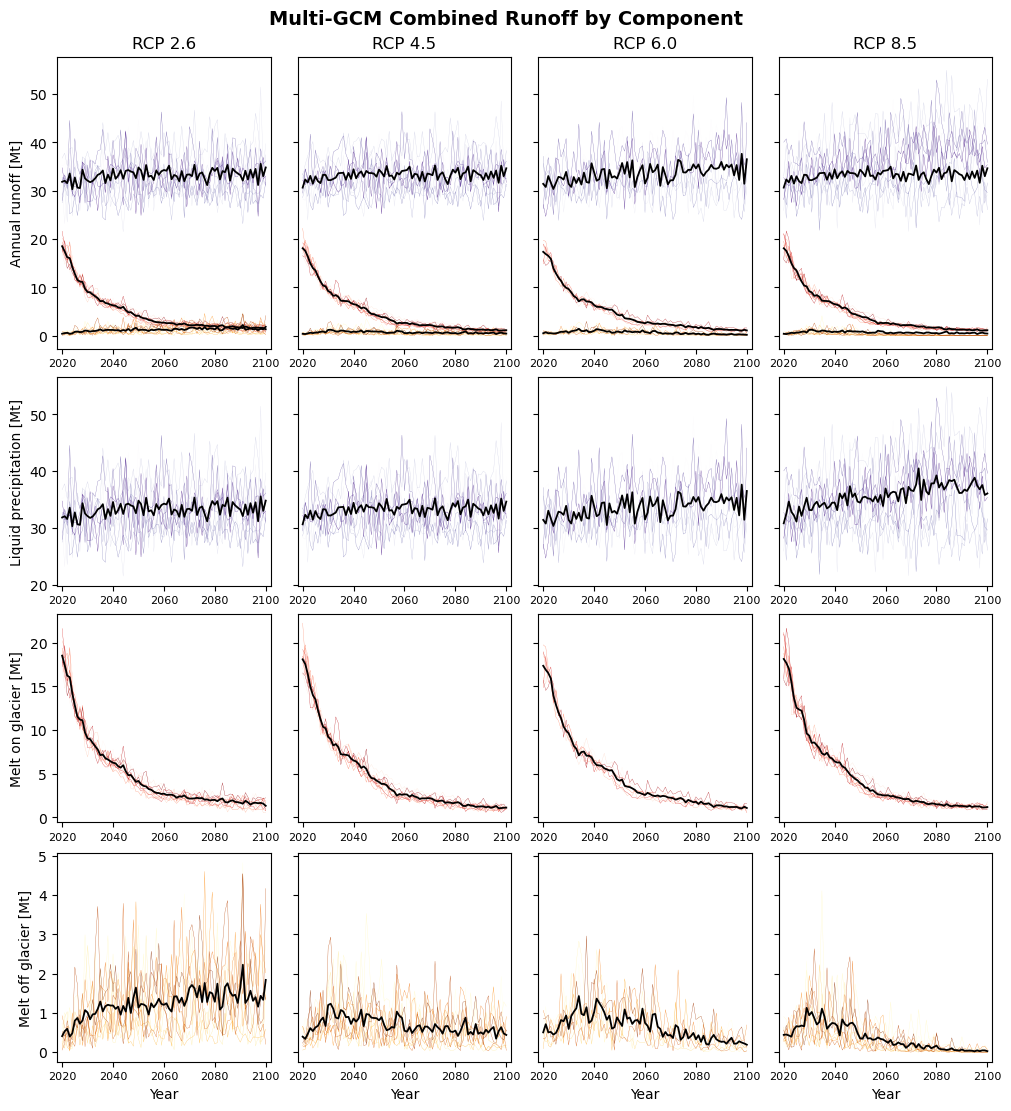

In [389]:
# Make the same figure as above but with diff runoff components
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, height_ratios=[1.4,1,1,1], figsize=(10,11), sharey='row', constrained_layout=True)

from matplotlib import cm
colorz = cm.get_cmap('Purples')
colorz2 = cm.get_cmap('Reds')
colorz3 = cm.get_cmap('YlOrBr')

# for c in columns:
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_on = rcp26_melt_on[c]
    years_toplot = pd.DataFrame(to_plot_melt_on).index + 2020
    ax1.plot(years_toplot, to_plot_melt_on.values, linewidth=0.2, label=c, color=colorz2(color_idx))
    to_plot_melt_off = rcp26_melt_off[c]
    ax1.plot(years_toplot, to_plot_melt_off.values, linewidth=0.2, label=c, color=colorz3(color_idx))             
    to_plot_prcp = rcp26_prcp[c]
    ax1.plot(years_toplot, to_plot_prcp.values, linewidth=0.2, label=c, color=colorz(color_idx))
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_on = rcp45_melt_on[c]
    ax2.plot(years_toplot, to_plot_melt_on.values, linewidth=0.2, color=colorz2(color_idx))
    to_plot_melt_off = rcp45_melt_off[c]
    ax2.plot(years_toplot, to_plot_melt_off.values, linewidth=0.2, color=colorz3(color_idx))             
    to_plot_prcp = rcp45_prcp[c]
    ax2.plot(years_toplot, to_plot_prcp.values, linewidth=0.2, color=colorz(color_idx))
for i,c in enumerate(columns_60):
    color_idx = i/len(columns_60)
    to_plot_melt_on = rcp60_melt_on[c]
    ax3.plot(years_toplot, to_plot_melt_on.values, linewidth=0.2, color=colorz2(color_idx))
    to_plot_melt_off = rcp60_melt_off[c]
    ax3.plot(years_toplot, to_plot_melt_off.values, linewidth=0.2, color=colorz3(color_idx))             
    to_plot_prcp = rcp60_prcp[c]
    ax3.plot(years_toplot, to_plot_prcp.values, linewidth=0.2, color=colorz(color_idx))
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_on = rcp85_melt_on[c]
    ax4.plot(years_toplot, to_plot_melt_on.values, linewidth=0.2, color=colorz2(color_idx))
    to_plot_melt_off = rcp85_melt_off[c]
    ax4.plot(years_toplot, to_plot_melt_off.values, linewidth=0.2, color=colorz3(color_idx))             
    to_plot_prcp = rcp85_prcp[c]
    ax4.plot(years_toplot, to_plot_prcp.values, linewidth=0.2, color=colorz(color_idx))

ax1.plot(years_toplot, to_df(rcp26_melt_on)['mean'].values, color='k', linewidth=1.3);
ax1.plot(years_toplot, to_df(rcp26_melt_off)['mean'].values, color='k', linewidth=1.3);
ax1.plot(years_toplot, to_df(rcp26_prcp)['mean'].values, color='k', linewidth=1.3);

ax2.plot(years_toplot, to_df(rcp45_melt_on)['mean'].values, color='k', linewidth=1.3);
ax2.plot(years_toplot, to_df(rcp45_melt_off)['mean'].values, color='k', linewidth=1.3);
ax2.plot(years_toplot, to_df(rcp45_prcp)['mean'].values, color='k', linewidth=1.3);

ax3.plot(years_toplot, to_df(rcp60_melt_on)['mean'].values, color='k', linewidth=1.3);
ax3.plot(years_toplot, to_df(rcp60_melt_off)['mean'].values, color='k', linewidth=1.3);
ax3.plot(years_toplot, to_df(rcp60_prcp)['mean'].values, color='k', linewidth=1.3);

ax4.plot(years_toplot, to_df(rcp45_melt_on)['mean'].values, color='k', linewidth=1.3);
ax4.plot(years_toplot, to_df(rcp45_melt_off)['mean'].values, color='k', linewidth=1.3);
ax4.plot(years_toplot, to_df(rcp45_prcp)['mean'].values, color='k', linewidth=1.3);

ax1.set(#xlabel = 'Year', 
        ylabel = "Annual runoff [Mt]", 
        title='RCP 2.6',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2018,2102))
ax2.set(#xlabel = 'Year', 
        #ylabel = "Annual runoff [Mt]", 
        title='RCP 4.5',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2018,2102))
ax3.set(#xlabel = 'Year', 
        #ylabel = "Annual runoff [Mt]", 
        title='RCP 6.0',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2018,2102))
ax4.set(#xlabel = 'Year', 
        #ylabel = "Annual runoff [Mt]", 
        title='RCP 8.5',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2018,2102))

ax1.tick_params(axis='x', which='major', labelsize=8)
ax2.tick_params(axis='x', which='major', labelsize=8)
ax3.tick_params(axis='x', which='major', labelsize=8)
ax4.tick_params(axis='x', which='major', labelsize=8)

plt.suptitle("Multi-GCM Combined Runoff by Component", fontweight='bold', fontsize=14);



# Make precipitation row
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_prcp = rcp26_prcp[c]
    ax5.plot(years_toplot, to_plot_prcp.values, linewidth = 0.2, color=colorz(color_idx))
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_prcp = rcp45_prcp[c]
    ax6.plot(years_toplot, to_plot_prcp.values, linewidth = 0.2, color=colorz(color_idx))
for i,c in enumerate(columns_60):
    color_idx = i/len(columns_60)
    to_plot_prcp = rcp60_prcp[c]
    ax7.plot(years_toplot, to_plot_prcp.values, linewidth = 0.2, color=colorz(color_idx))
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_prcp = rcp85_prcp[c]
    ax8.plot(years_toplot, to_plot_prcp.values, linewidth = 0.2, color=colorz(color_idx))

ax5.plot(years_toplot, rcp26_prcp['mean'].values, color='k', linewidth=1.3);
ax6.plot(years_toplot, rcp45_prcp['mean'].values, color='k', linewidth=1.3);
ax7.plot(years_toplot, rcp60_prcp['mean'].values, color='k', linewidth=1.3);
ax8.plot(years_toplot, rcp85_prcp['mean'].values, color='k', linewidth=1.3);

ax5.set(#xlabel = 'Year', 
        ylabel = "Liquid precipitation [Mt]", 
        #title='RCP 2.6',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2018,2102))
ax6.set(#xlabel = 'Year', 
        #ylabel = "Annual runoff [Mt]", 
        #title='RCP 4.5',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2018,2102))
ax7.set(#xlabel = 'Year', 
        #ylabel = "Annual runoff [Mt]", 
        #title='RCP 6.0',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2018,2102))
ax8.set(#xlabel = 'Year', 
        #ylabel = "Annual runoff [Mt]", 
        #title='RCP 8.5',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2018,2102))

ax5.tick_params(axis='x', which='major', labelsize=8)
ax6.tick_params(axis='x', which='major', labelsize=8)
ax7.tick_params(axis='x', which='major', labelsize=8)
ax8.tick_params(axis='x', which='major', labelsize=8)


# # Make second row (melt on)
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_on = rcp26_melt_on[c]
    ax9.plot(years_toplot, to_plot_melt_on.values, linewidth = 0.2, color=colorz2(color_idx))
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_on = rcp45_melt_on[c]
    ax10.plot(years_toplot, to_plot_melt_on.values, linewidth = 0.2, color=colorz2(color_idx))
for i,c in enumerate(columns_60):
    color_idx = i/len(columns_60)
    to_plot_melt_on = rcp60_melt_on[c]
    ax11.plot(years_toplot, to_plot_melt_on.values, linewidth = 0.2, color=colorz2(color_idx))
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_on = rcp85_melt_on[c]
    ax12.plot(years_toplot, to_plot_melt_on.values, linewidth = 0.2, color=colorz2(color_idx))

ax9.plot(years_toplot, to_df(rcp26_melt_on)['mean'].values, color='k', linewidth=1.3);
ax10.plot(years_toplot, to_df(rcp45_melt_on)['mean'].values, color='k', linewidth=1.3);
ax11.plot(years_toplot, to_df(rcp60_melt_on)['mean'].values, color='k', linewidth=1.3);
ax12.plot(years_toplot, to_df(rcp85_melt_on)['mean'].values, color='k', linewidth=1.3);

ax9.set(#xlabel = 'Year', 
        ylabel = "Melt on glacier [Mt]", 
        #title='RCP 2.6',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2018,2102))
ax10.set(#xlabel = 'Year', 
        #ylabel = "Annual runoff [Mt]", 
        #title='RCP 4.5',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2018,2102))
ax11.set(#xlabel = 'Year', 
        #ylabel = "Annual runoff [Mt]", 
        #title='RCP 6.0',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2018,2102))
ax12.set(#xlabel = 'Year', 
        #ylabel = "Annual runoff [Mt]", 
        #title='RCP 8.5',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2018,2102))

ax9.tick_params(axis='x', which='major', labelsize=8)
ax10.tick_params(axis='x', which='major', labelsize=8)
ax11.tick_params(axis='x', which='major', labelsize=8)
ax12.tick_params(axis='x', which='major', labelsize=8)



# for c in columns:
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_off = rcp26_melt_off[c]
    ax13.plot(years_toplot, to_plot_melt_off.values, linewidth = 0.2, color=colorz3(color_idx))
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_off = rcp45_melt_off[c]
    ax14.plot(years_toplot, to_plot_melt_off.values, linewidth = 0.2, color=colorz3(color_idx))
for i,c in enumerate(columns_60):
    color_idx = i/len(columns_60)
    to_plot_melt_off = rcp60_melt_off[c]
    ax15.plot(years_toplot, to_plot_melt_off.values, linewidth = 0.2, color=colorz3(color_idx))
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_off = rcp85_melt_off[c]
    ax16.plot(years_toplot, to_plot_melt_off.values, linewidth = 0.2, color=colorz3(color_idx))
    
ax13.plot(years_toplot, to_df(rcp26_melt_off)['mean'].values, color='k', linewidth=1.3);
ax14.plot(years_toplot, to_df(rcp45_melt_off)['mean'].values, color='k', linewidth=1.3);
ax15.plot(years_toplot, to_df(rcp60_melt_off)['mean'].values, color='k', linewidth=1.3);
ax16.plot(years_toplot, to_df(rcp85_melt_off)['mean'].values, color='k', linewidth=1.3);


ax13.set(xlabel = 'Year', 
        ylabel = "Melt off glacier [Mt]", 
        #title='RCP 2.6',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2018,2102))
ax14.set(xlabel = 'Year', 
        #ylabel = "Annual runoff [Mt]", 
        #title='RCP 4.5',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2018,2102))
ax15.set(xlabel = 'Year', 
        #ylabel = "Annual runoff [Mt]", 
        #title='RCP 6.0',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2018,2102))
ax16.set(xlabel = 'Year', 
        #ylabel = "Annual runoff [Mt]", 
        #title='RCP 8.5',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2018,2102))

ax13.tick_params(axis='x', which='major', labelsize=8)
ax14.tick_params(axis='x', which='major', labelsize=8)
ax15.tick_params(axis='x', which='major', labelsize=8)
ax16.tick_params(axis='x', which='major', labelsize=8)

# plt.suptitle("Multi-GCM Runoff by Component", fontweight='bold');

#plt.savefig('Figures/Annual/runoff_comp_remake_may5.png', bbox_inches='tight')

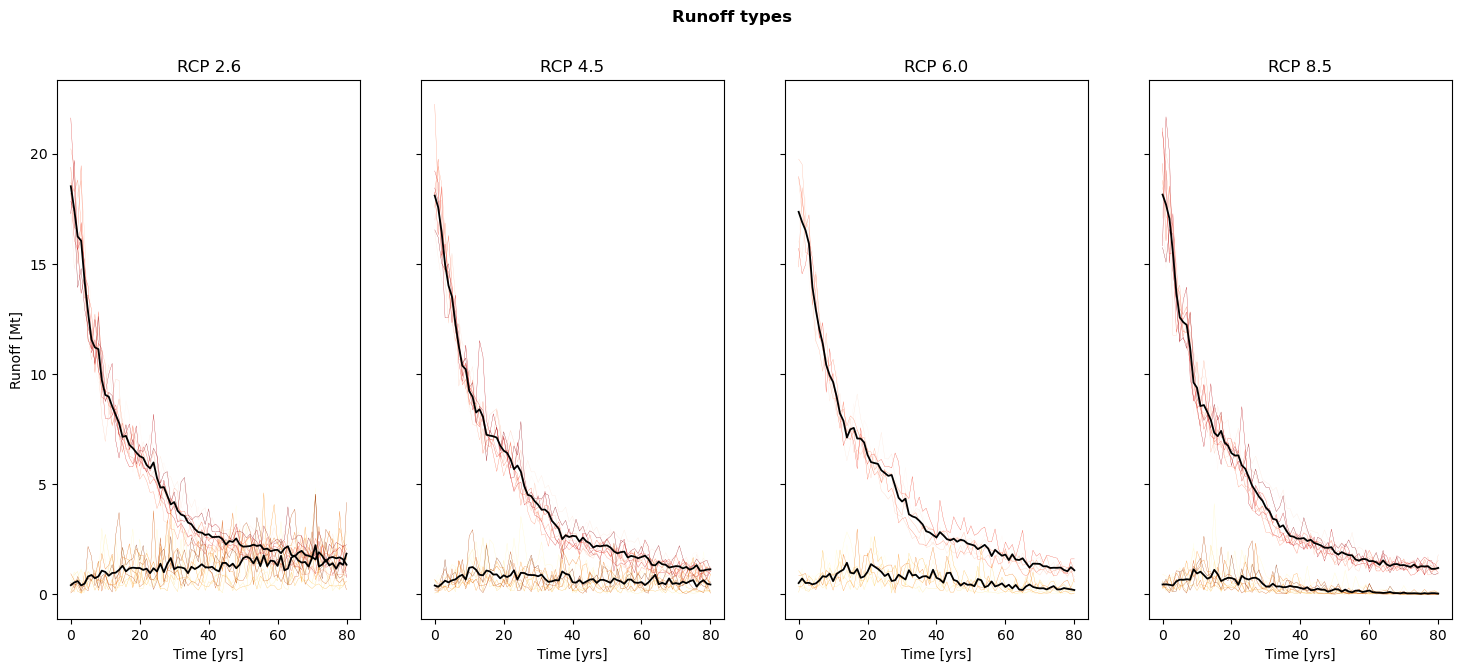

In [118]:
# Same plot but with only melt components shown!
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 7), sharey=True)

from matplotlib import cm
colorz3 = cm.get_cmap('YlOrBr')
colorz2 = cm.get_cmap('Reds')

for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_on = rcp26_melt_on[c]
    to_plot_melt_on.plot(ax=ax1, linewidth=0.2, label=c, color=colorz2(color_idx))
    to_plot_melt_off = rcp26_melt_off[c]
    to_plot_melt_off.plot(ax=ax1, linewidth=0.2, label=c, color=colorz3(color_idx))
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_on = rcp45_melt_on[c]
    to_plot_melt_on.plot(ax=ax2, linewidth=0.2, color=colorz2(color_idx))
    to_plot_melt_off = rcp45_melt_off[c]
    to_plot_melt_off.plot(ax=ax2, linewidth=0.2, color=colorz3(color_idx))
for i,c in enumerate(columns_60):
    color_idx = i/len(columns)
    to_plot_melt_on = rcp60_melt_on[c]
    to_plot_melt_on.plot(ax=ax3, linewidth=0.2, color=colorz2(color_idx))
    to_plot_melt_off = rcp60_melt_off[c]
    to_plot_melt_off.plot(ax=ax3, linewidth=0.2, color=colorz3(color_idx))
for i,c in enumerate(columns):
    color_idx = i/len(columns)
    to_plot_melt_on = rcp85_melt_on[c]
    to_plot_melt_on.plot(ax=ax4, linewidth=0.2, color=colorz2(color_idx))
    to_plot_melt_off = rcp85_melt_off[c]
    to_plot_melt_off.plot(ax=ax4, linewidth=0.2, color=colorz3(color_idx))
    
rcp26_melt_on['mean'].plot(ax=ax1, color='k', label='GCM mean', linewidth=1.3);
rcp26_melt_off['mean'].plot(ax=ax1, color='k', label='GCM mean', linewidth=1.3);

rcp45_melt_on['mean'].plot(ax=ax2, color='k', label='GCM mean', linewidth=1.3);
rcp45_melt_off['mean'].plot(ax=ax2, color='k', label='GCM mean', linewidth=1.3);

rcp60_melt_on['mean'].plot(ax=ax3, color='k', label='', linewidth=1.3);
rcp60_melt_off['mean'].plot(ax=ax3, color='k', label='', linewidth=1.3);

rcp85_melt_on['mean'].plot(ax=ax4, color='k', label='GCM mean', linewidth=1.3);
rcp85_melt_off['mean'].plot(ax=ax4, color='k', label='GCM mean', linewidth=1.3);

#plt.legend(bbox_to_anchor=(1.05, 1))
ax1.set(ylabel='Runoff [Mt]', title='RCP 2.6')
ax2.set(title='RCP 4.5')
ax3.set(title='RCP 6.0')
ax4.set(title='RCP 8.5');
for ax in (ax1,ax2,ax3,ax4):
    ax.set(xlabel = 'Time [yrs]'
          );

plt.suptitle("Runoff types", fontweight='bold');

In [ ]:
# To find slope of line: np.mean(diff(whatever your series is))

# <b> Visualizations of volume

The following code chunk is now outdated, use the next one!

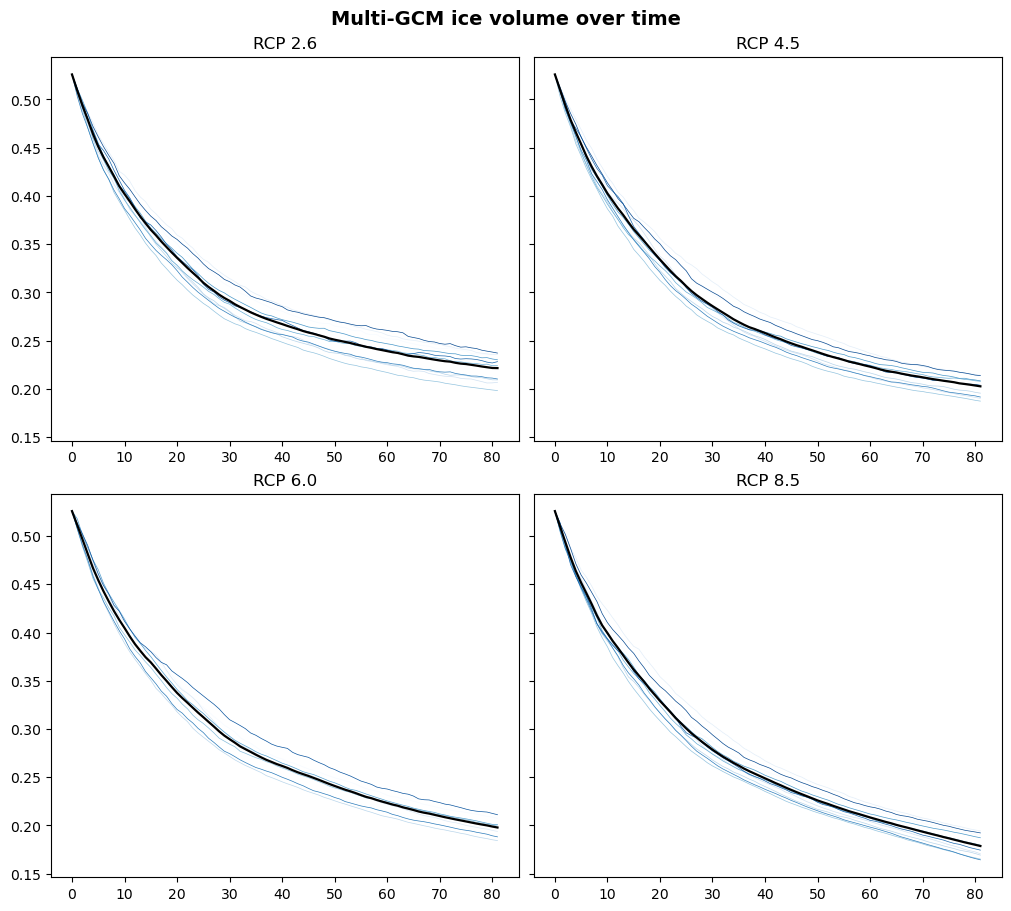

In [265]:
# All GCM volumes by RCP
from matplotlib import cm
color_v = cm.get_cmap('Blues')

v26_keys = rcp26_volume.keys()
v45_keys = rcp45_volume.keys()
v60_keys = rcp60_volume.keys()
v85_keys = rcp85_volume.keys()

#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 7), sharey=True)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 9), sharey=True, constrained_layout = True)

# From above to fix axes:
# for i,k in enumerate(rcp26_dict.keys()):
#     color_idx = i/len(rcp26_dict.keys())
#     to_plot = rcp26_dict[k]
#     toplot_df = pd.DataFrame(to_plot)
#     years_toplot = toplot_df.index + 2020
#     ax1.plot(years_toplot, toplot_df.values, linewidth=0.2, label='', color=color_runoff(color_idx))

# ax1.set(#xlabel = 'Year', 
#         ylabel = "Annual runoff [Mt]", 
#         title='RCP 2.6',
#         xticks = (2020, 2040, 2060, 2080, 2100),
#         xlim = (2019,2101))

def to_df(dataframe):
    my_df = pd.DataFrame(dataframe)
    my_df['mean'] = my_df.transpose().mean(axis=0)
    return my_df

for i,k in enumerate(v26_keys):
    color_idx = i/len(v26_keys)
    to_plot = rcp26_volume[k]
    ax1.plot(to_plot, linewidth=0.5, label=k, color=color_v(color_idx))
for i,k in enumerate(v45_keys):
    color_idx = i/len(v45_keys)
    to_plot = rcp45_volume[k]
    ax2.plot(to_plot, linewidth=0.5, label=k, color=color_v(color_idx))
for i,k in enumerate(v60_keys):
    color_idx = i/len(v60_keys)
    to_plot = rcp60_volume[k]
    ax3.plot(to_plot, linewidth=0.5, label=k, color=color_v(color_idx))
for i,k in enumerate(v85_keys):
    color_idx = i/len(v85_keys)
    to_plot = rcp85_volume[k]
    ax4.plot(to_plot, linewidth=0.5, label=k, color=color_v(color_idx))

ax1.plot(rcp26_df_v['mean'], color='k', label='GCM mean', linewidth=1.6)
ax2.plot(rcp45_df_v['mean'], color='k', label='GCM mean', linewidth=1.6)
ax3.plot(rcp60_df_v['mean'], color='k', label='GCM mean', linewidth=1.6)
ax4.plot(rcp85_df_v['mean'], color='k', label='GCM mean', linewidth=1.6)

#plt.legend(bbox_to_anchor=(1.05, 1))

# ax1.set(xlabel = 'Time [years]', ylabel='Volume [km3]', title='RCP 2.6');
# ax2.set(xlabel = 'Time [years]', title='RCP 4.5');
# ax3.set(xlabel = 'Time [years]', title='RCP 6.0');
# ax4.set(xlabel = 'Time [years]', title='RCP 8.5');

ax1.set(title='RCP 2.6');
ax2.set(title='RCP 4.5');
ax3.set(title='RCP 6.0');
ax4.set(title='RCP 8.5');

plt.suptitle("Multi-GCM ice volume over time", fontweight='bold', fontsize = 14);
#plt.savefig('Figures/Annual/volume_updated_4_2_2x2plot.png', bbox_inches='tight')

This code chunk works and has correct axes for the GCM volumes!

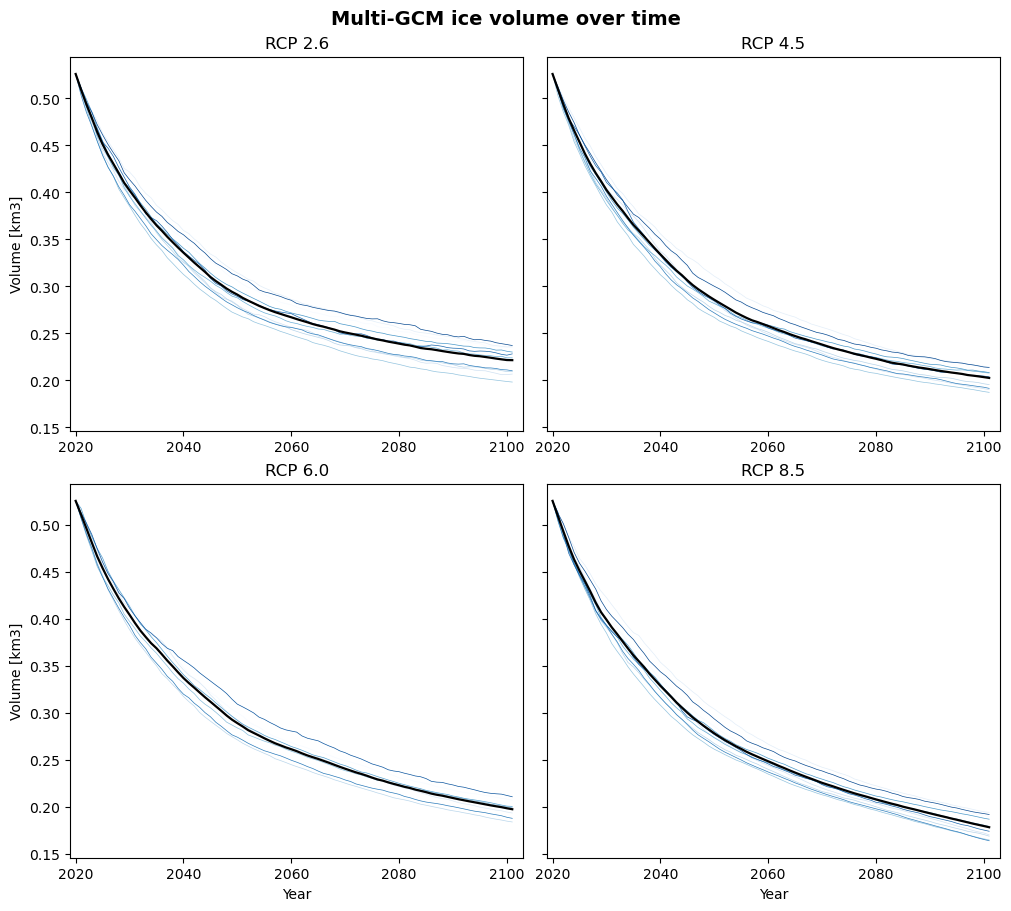

In [334]:
# All GCM volumes by RCP
# Updated with new axes!!!
from matplotlib import cm
color_v = cm.get_cmap('Blues')

v26_keys = rcp26_volume.keys()
v45_keys = rcp45_volume.keys()
v60_keys = rcp60_volume.keys()
v85_keys = rcp85_volume.keys()

#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 7), sharey=True)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 9), sharey=True, constrained_layout = True)

for i,k in enumerate(v26_keys):
    color_idx = i/len(v26_keys)
    to_plot = rcp26_df_v[k]
    years_toplot = to_plot.index + 2020
    ax1.plot(years_toplot, to_plot.values, linewidth=0.5, label=k, color=color_v(color_idx))
for i,k in enumerate(v45_keys):
    color_idx = i/len(v45_keys)
    to_plot = rcp45_df_v[k]
    ax2.plot(years_toplot, to_plot.values, linewidth=0.5, label=k, color=color_v(color_idx))
for i,k in enumerate(v60_keys):
    color_idx = i/len(v60_keys)
    to_plot = rcp60_df_v[k]
    ax3.plot(years_toplot, to_plot.values, linewidth=0.5, label=k, color=color_v(color_idx))
for i,k in enumerate(v85_keys):
    color_idx = i/len(v85_keys)
    to_plot = rcp85_df_v[k]
    ax4.plot(years_toplot, to_plot.values, linewidth=0.5, label=k, color=color_v(color_idx))

ax1.plot(years_toplot, rcp26_df_v['mean'].values, color='k', label='GCM mean', linewidth=1.6)
ax2.plot(years_toplot, rcp45_df_v['mean'].values, color='k', label='GCM mean', linewidth=1.6)
ax3.plot(years_toplot, rcp60_df_v['mean'].values, color='k', label='GCM mean', linewidth=1.6)
ax4.plot(years_toplot, rcp85_df_v['mean'].values, color='k', label='GCM mean', linewidth=1.6)

#plt.legend(bbox_to_anchor=(1.05, 1))

ax1.set(#xlabel = 'Year', 
        ylabel = "Volume [km3]", 
        title = 'RCP 2.6',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2019,2103))
ax2.set(#xlabel = 'Year', 
        #ylabel = "Volume [km3]", 
        title='RCP 4.5',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2019,2103))
ax3.set(xlabel = 'Year', 
        ylabel = "Volume [km3]", 
        title='RCP 6.0',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2019,2103))
ax4.set(xlabel = 'Year', 
        #ylabel = "Volume [km3]", 
        title='RCP 8.5',
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2019,2103))

plt.suptitle("Multi-GCM ice volume over time", fontweight='bold', fontsize = 14);

#plt.savefig('Figures/Annual/volume_GCM_may4.png', bbox_inches='tight')

### RCP2.6

In [123]:
gcm_list = ['CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'MPI-ESM-LR', 'NorESM1-M']
date_list = ['2023-01-12', '2023-01-23', '2023-01-17', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-25', '2023-01-25', '2023-01-25']
base = '~/Documents/Molly-thesis/Data/'
rcp='rcp26'

runoff = 'volume'
rcp26_volume = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

In [124]:
rcp26_df_v = pd.DataFrame(rcp26_volume)

rcp26_df_v['mean'] = rcp26_df_v.transpose().mean()
#rcp_mean = rcp26_df.transpose().rolling(window=4).mean()

Text(0.5, 1.0, 'RCP2.6')

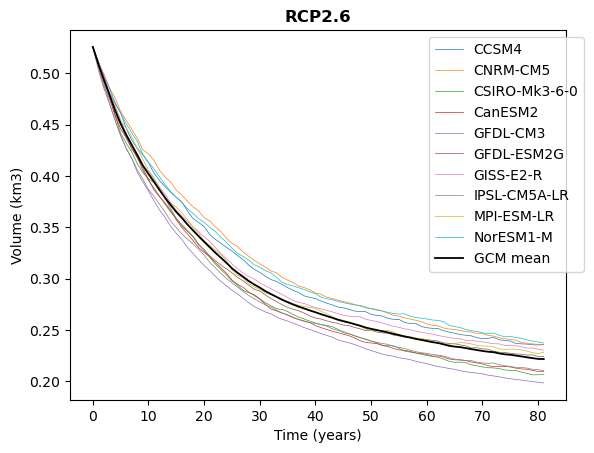

In [114]:
fig, ax = plt.subplots()
for k in rcp26_volume.keys():
     to_plot = rcp26_volume[k]
     ax.plot(to_plot, linewidth=0.5, label=k)
ax.plot(rcp26_df_v['mean'], color='k', label='GCM mean', linewidth=1.3)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('Time (years)')
plt.ylabel('Volume (km3)')
plt.title('RCP2.6', fontweight='bold')

#plt.savefig('rcp26_mean_2023-01-31.png', bbox_inches='tight')

### RCP 4.5

In [125]:
gcm_list = ['CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'MPI-ESM-LR', 'NorESM1-M']
date_list = ['2023-01-12', '2023-01-23', '2023-01-17', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-25', '2023-01-25', '2023-01-25']
base = '~/Documents/Molly-thesis/Data/'
rcp='rcp45'
runoff = 'volume'

rcp45_volume = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

In [126]:
rcp45_df_v = pd.DataFrame(rcp45_volume)

rcp45_df_v['mean'] = rcp45_df_v.transpose().mean()
#rcp_mean = rcp26_df.transpose().rolling(window=4).mean()

Text(0.5, 1.0, 'RCP4.5')

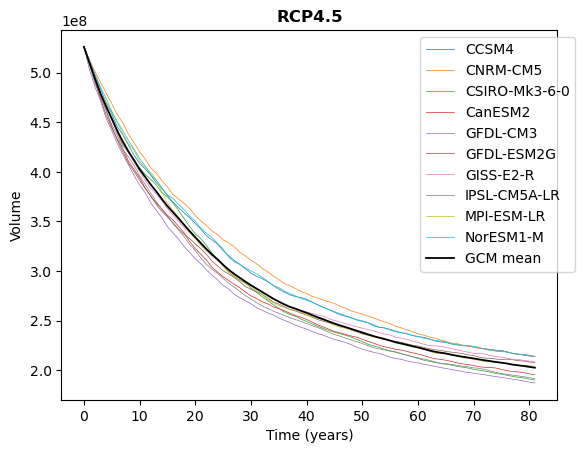

In [144]:
fig, ax = plt.subplots()
for k in rcp45_volume.keys():
     to_plot = rcp45_volume[k]
     ax.plot(to_plot, linewidth=0.5, label=k)
ax.plot(rcp45_df_v['mean'], color='k', label='GCM mean', linewidth=1.3)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('Time (years)')
plt.ylabel('Volume')
plt.title('RCP4.5', fontweight='bold')

#plt.savefig('rcp26_mean_2023-01-31.png', bbox_inches='tight')

### RCP 6.0

In [127]:
gcm_list = ['CCSM4', 'CSIRO-Mk3-6-0', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'NorESM1-M']
date_list = ['2023-01-12', '2023-01-17', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-25', '2023-01-25']
base = '~/Documents/Molly-thesis/Data/'
rcp='rcp60'
runoff = 'volume'

rcp60_volume = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

In [128]:
rcp60_df_v = pd.DataFrame(rcp60_volume)

rcp60_df_v['mean'] = rcp60_df_v.transpose().mean()
#rcp_mean = rcp26_df.transpose().rolling(window=4).mean()

Text(0.5, 1.0, 'RCP6.0')

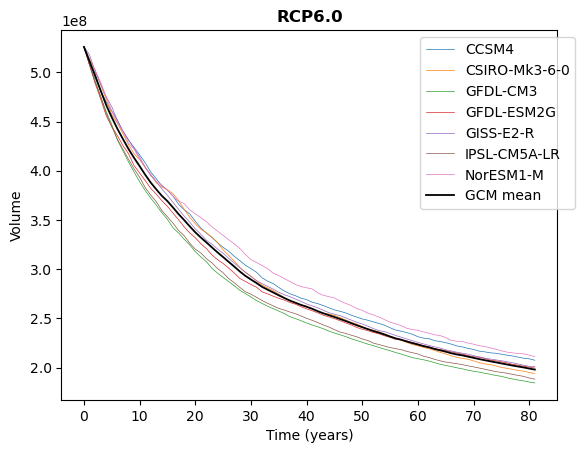

In [147]:
fig, ax = plt.subplots()
for k in rcp60_volume.keys():
     to_plot = rcp60_volume[k]
     ax.plot(to_plot, linewidth=0.5, label=k)
ax.plot(rcp60_df_v['mean'], color='k', label='GCM mean', linewidth=1.3)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('Time (years)')
plt.ylabel('Volume')
plt.title('RCP6.0', fontweight='bold')

#plt.savefig('rcp26_mean_2023-01-31.png', bbox_inches='tight')

In [129]:
gcm_list = ['CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'MPI-ESM-LR', 'NorESM1-M']
date_list = ['2023-01-12', '2023-01-23', '2023-01-17', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-25', '2023-01-25', '2023-01-25']
base = '~/Documents/Molly-thesis/Data/'
rcp='rcp85'
runoff = 'volume'

rcp85_volume = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

In [130]:
rcp85_df_v = pd.DataFrame(rcp85_volume)

rcp85_df_v['mean'] = rcp85_df_v.transpose().mean()
#rcp_mean = rcp26_df.transpose().rolling(window=4).mean()

Text(0.5, 1.0, 'RCP8.5')

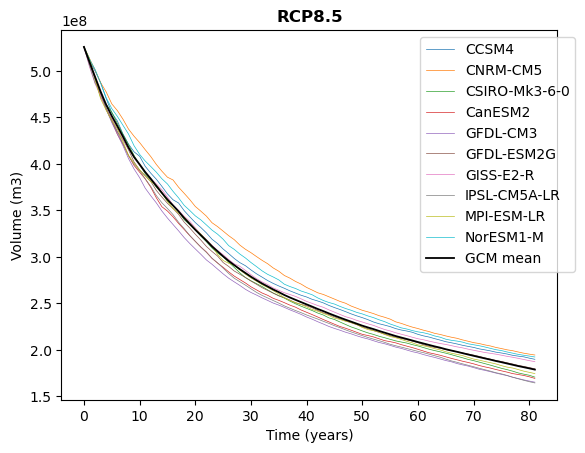

In [153]:
fig, ax = plt.subplots()
for k in rcp85_volume.keys():
     to_plot = rcp85_volume[k]
     ax.plot(to_plot, linewidth=0.5, label=k)
ax.plot(rcp85_df_v['mean'], color='k', label='GCM mean', linewidth=1.3)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('Time (years)')
plt.ylabel('Volume (m3)')
plt.title('RCP8.5', fontweight='bold')

#plt.savefig('rcp26_mean_2023-01-31.png', bbox_inches='tight')

### All mean volumes together

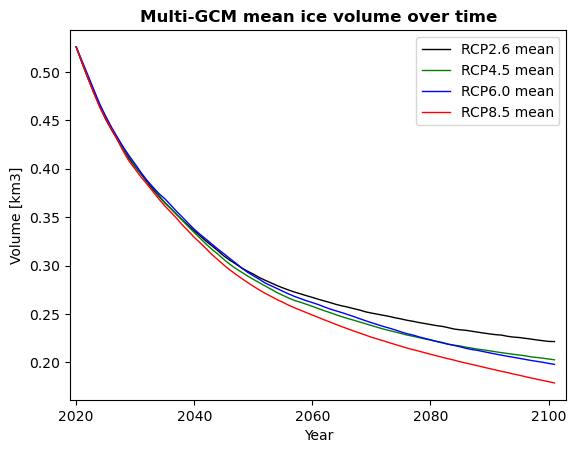

In [343]:
fig, ax = plt.subplots()

years_toplot = rcp26_df_v.index + 2020

ax.plot(years_toplot, rcp26_df_v['mean'].values, color='k', label='RCP2.6 mean', linewidth=1.0)
ax.plot(years_toplot, rcp45_df_v['mean'].values, color='g', label='RCP4.5 mean', linewidth=1.0)
ax.plot(years_toplot, rcp60_df_v['mean'].values, color='b', label='RCP6.0 mean', linewidth=1.0)
ax.plot(years_toplot, rcp85_df_v['mean'].values, color='r', label='RCP8.5 mean', linewidth=1.0)
plt.legend()
plt.xlabel('Time [years]')
plt.ylabel('Volume [km3]')
plt.title('Multi-GCM mean ice volume over time', fontweight='bold')

ax.set( xlabel = 'Year', 
        ylabel = "Volume [km3]", 
        xticks = (2020, 2040, 2060, 2080, 2100),
        xlim = (2019,2103));

#plt.savefig('Figures/Annual/rcp_mean_volume_may4.png', bbox_inches='tight')

## <b> Look at Area

RCP 2.6

In [86]:
gcm_list = ['CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'MPI-ESM-LR', 'NorESM1-M']
date_list = ['2023-01-12', '2023-01-23', '2023-01-17', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-25', '2023-01-25', '2023-01-25']
base = '~/Documents/Molly-thesis/Data/'
rcp='rcp26'

runoff = 'area'
rcp26_area = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

In [90]:
rcp26_df_a = pd.DataFrame(rcp26_area)

rcp26_df_a['mean'] = rcp26_df_a.transpose().mean()*1e3
#rcp_mean = rcp26_df.transpose().rolling(window=4).mean()

Text(0.5, 1.0, 'RCP2.6')

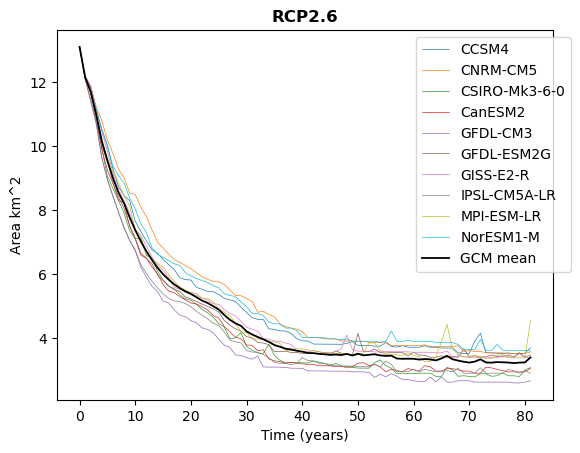

In [92]:
fig, ax = plt.subplots()
for k in rcp26_area.keys():
     to_plot = rcp26_area[k]*1e3
     ax.plot(to_plot, linewidth=0.5, label=k)
ax.plot(rcp26_df_a['mean'], color='k', label='GCM mean', linewidth=1.3)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('Time (years)')
plt.ylabel('Area km^2')
plt.title('RCP2.6', fontweight='bold')

#plt.savefig('rcp26_mean_2023-01-31.png', bbox_inches='tight')

In [ ]:
# 6.0
gcm_list = ['CCSM4', 'CSIRO-Mk3-6-0', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'NorESM1-M']
date_list = ['2023-01-12', '2023-01-17', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-25', '2023-01-25']
base = '~/Documents/Molly-thesis/Data/'
rcp='rcp60'
runoff = 'volume'

rcp60_volume = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

In [ ]:
rcp60_df_v = pd.DataFrame(rcp60_volume)

rcp60_df_v['mean'] = rcp60_df_v.transpose().mean()
#rcp_mean = rcp26_df.transpose().rolling(window=4).mean()

In [ ]:
fig, ax = plt.subplots()
for k in rcp60_volume.keys():
     to_plot = rcp60_volume[k]
     ax.plot(to_plot, linewidth=0.5, label=k)
ax.plot(rcp60_df_v['mean'], color='k', label='GCM mean', linewidth=1.3)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('Time (years)')
plt.ylabel('Volume')
plt.title('RCP6.0', fontweight='bold')

#plt.savefig('rcp26_mean_2023-01-31.png', bbox_inches='tight')

## <b> Looking at seasonality

# The code beyond this point is outdated - the newest versions are held in Seasonal_updated

In [3]:
# Look at the variables that we have!
base = ("~/Documents/Molly-thesis/Data/2023-01-12-gcm_data_CCSM4_rcp26_compiled_output.nc")
sample_ds = xr.open_dataset(base)
sample_ds

<xarray.Dataset>
Dimensions:                       (time: 82, rgi_id: 35, month_2d: 12)
Coordinates:
  * time                          (time) float64 2.02e+03 ... 2.101e+03
  * rgi_id                        (rgi_id) object 'RGI60-16.00495' ... 'RGI60...
    hydro_year                    (time) int64 ...
    hydro_month                   (time) int64 ...
    calendar_year                 (time) int64 ...
    calendar_month                (time) int64 ...
  * month_2d                      (month_2d) int64 1 2 3 4 5 6 7 8 9 10 11 12
    calendar_month_2d             (month_2d) int64 ...
Data variables: (12/24)
    volume                        (time, rgi_id) float32 ...
    volume_bsl                    (time, rgi_id) float32 ...
    volume_bwl                    (time, rgi_id) float32 ...
    area                          (time, rgi_id) float32 ...
    length                        (time, rgi_id) float32 ...
    calving                       (time, rgi_id) float32 ...
    ...                            ...
    liq_prcp_on_glacier_monthly   (time, month_2d, rgi_id) float32 ...
    snowfall_off_glacier_monthly  (time, month_2d, rgi_id) float32 ...
    snowfall_on_glacier_monthly   (time, month_2d, rgi_id) float32 ...
    water_level                   (rgi_id) float32 ...
    glen_a                        (rgi_id) float32 ...
    fs                            (rgi_id) float32 ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.5.3
    calendar:       365-day no leap
    creation_date:  2023-01-12 16:51:46

In [4]:
# Load dataset and sum in one step
def seasonal_sum_series(fpath_stem, which_date, which_gcm, which_rcp):
    this_fpath = fpath_stem+'{}-gcm_data_{}_{}_compiled_output.nc'.format(which_date, which_gcm, which_rcp)
    this_ds = xr.open_dataset(this_fpath)
    melt1 = this_ds.melt_on_glacier_monthly
    melt2 = this_ds.melt_off_glacier_monthly
    melt3 = this_ds.liq_prcp_off_glacier_monthly
    melt4 = this_ds.liq_prcp_on_glacier_monthly
    
    this_sum = melt1.sum(dim='rgi_id').dropna(dim='time') + melt2.sum(dim='rgi_id').dropna(dim='time') + melt3.sum(dim='rgi_id').dropna(dim='time') + melt4.sum(dim='rgi_id').dropna(dim='time')
    nonzero_sum = this_sum.where(this_sum!=0, drop=True)
    return nonzero_sum

In [5]:
# In contrast to the step above, load only the dataset
def open_series(fpath_stem, which_date, which_gcm, which_rcp):
    this_fpath = fpath_stem+'{}-gcm_data_{}_{}_compiled_output.nc'.format(which_date, which_gcm, which_rcp)
    this_ds = xr.open_dataset(this_fpath)
    return this_ds

In [6]:
# Now, perform the calculations using the existing dataset
def calc_seasonal(this_ds):
    melt1 = this_ds.melt_on_glacier_monthly
    melt2 = this_ds.melt_off_glacier_monthly
    melt3 = this_ds.liq_prcp_off_glacier_monthly
    melt4 = this_ds.liq_prcp_on_glacier_monthly
    
    this_sum = melt1.sum(dim='rgi_id').dropna(dim='time') + melt2.sum(dim='rgi_id').dropna(dim='time') + melt3.sum(dim='rgi_id').dropna(dim='time') + melt4.sum(dim='rgi_id').dropna(dim='time')
    nonzero_sum = this_sum.where(this_sum!=0, drop=True)
    return nonzero_sum

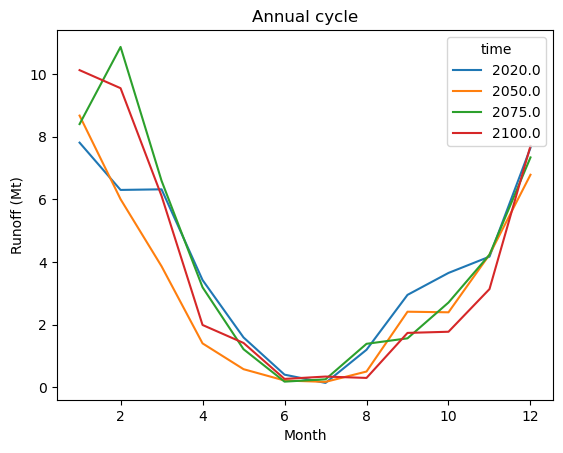

In [47]:
# Choose your gcm x date x rcp combo and plot it on an annual cycle for a given time!
gcm = 'CCSM4'
dte = '2023-01-12'
base = '~/Documents/Molly-thesis/Data/'
rcp='rcp45'

ccsm4_seasonal_rcp26 = open_series(base, dte, gcm, rcp)

ds_roll = ccsm4_seasonal_rcp26.roll(month_2d=ccsm4_seasonal_rcp26['calendar_month_2d'].data[0]-1, roll_coords=True)
ds_roll['month_2d'] = ds_roll['calendar_month_2d']

ccsm4_season_2 = calc_seasonal(ds_roll)
ccsm4_season_2 *= 1e-9

#ccsm4_season_2.clip(0).plot(cmap='Blues', cbar_kwargs={'label':'Mt'}); plt.xlabel('Months'); plt.ylabel('Years');
ccsm4_season_2.sel(time=[2020, 2050, 2075, 2100]).plot(hue='time'); plt.title('Annual cycle'); plt.xlabel('Month'); plt.ylabel('Runoff (Mt)');

In [48]:
df_temp = ds_roll.sum(dim='rgi_id')
df_tempdf_temp = ds_roll.sum(dim='rgi_id')
df_temp

<xarray.Dataset>
Dimensions:                       (time: 82, month_2d: 12)
Coordinates:
  * time                          (time) float64 2.02e+03 ... 2.101e+03
    hydro_year                    (time) int64 ...
    hydro_month                   (time) int64 ...
    calendar_year                 (time) int64 ...
    calendar_month                (time) int64 ...
  * month_2d                      (month_2d) int64 1 2 3 4 5 6 7 8 9 10 11 12
    calendar_month_2d             (month_2d) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/24)
    volume                        (time) float32 5.259e+08 ... 2.138e+08
    volume_bsl                    (time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    volume_bwl                    (time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    area                          (time) float32 1.31e+07 ... 2.946e+06
    length                        (time) float32 1.988e+04 ... 6.424e+03
    calving                       (time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                            ...
    liq_prcp_on_glacier_monthly   (time, month_2d) float32 3.006e+09 ... 0.0
    snowfall_off_glacier_monthly  (time, month_2d) float32 3.003e+06 ... 0.0
    snowfall_on_glacier_monthly   (time, month_2d) float32 5.227e+08 ... 0.0
    water_level                   float32 0.0
    glen_a                        float32 3.501e-23
    fs                            float32 1.539e-18

In [49]:
# Calculate different decades
runoff = ['melt_on_glacier_monthly', 'melt_off_glacier_monthly', 'liq_prcp_off_glacier_monthly', 'liq_prcp_on_glacier_monthly']

# Pick the first decade and average it
df_m_s = df_temp.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
# Rename the columns for readability
df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
# Because of floating point precision sometimes runoff can be slightly below zero, clip
df_m_s = df_m_s.clip(0)

# Same for end
df_m_e = df_temp.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
df_m_e = df_m_e.clip(0)

In [42]:
df_m_s
for col in df_m_s.columns:
    print(col)

calendar_month_2d
volume
volume_bsl
volume_bwl
area
length
calving
calving_rate
off_area
on_area
melt_off_glacier
melt_on_glacier
liq_prcp_off_glacier
liq_prcp_on_glacier
snowfall_off_glacier
snowfall_on_glacier
melt_off_glacier_m
melt_on_glacier_m
liq_prcp_off_glacier_m
liq_prcp_on_glacier_m
snowfall_off_glacier_m
snowfall_on_glacier_m
water_level
glen_a
fs


In [50]:
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']

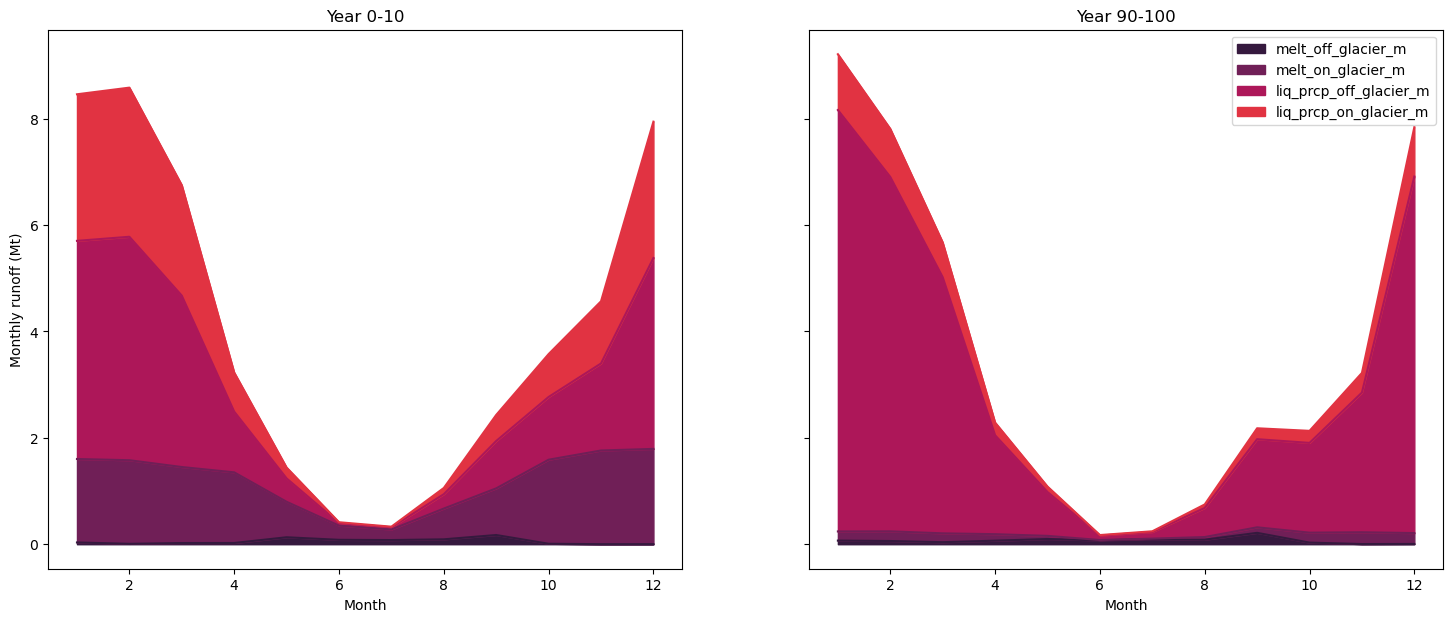

In [51]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);
df_m_s[runoff_variables].plot.area(ax=ax1, legend=False, title='Year 0-10', color=sns.color_palette("rocket"));
df_m_e[runoff_variables].plot.area(ax=ax2, title='Year 90-100', color=sns.color_palette("rocket"));
ax1.set_ylabel('Monthly runoff (Mt)'); ax1.set_xlabel('Month'); ax2.set_xlabel('Month');

### OUTDATED CODE

In [12]:
# Look at averages for a given time period - THIS DOESN'T WORK RIGHT NOW!
# Pick the variables we need (the 2d ones)
sel_vars = [v for v in ds_roll.variables if 'month_2d' in ds_roll[v].dims]

# Pick the first decade and average it
df_m_s = ds_roll[sel_vars].isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
# Rename the columns for readability
df_m_s.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
# Because of floating point precision sometimes runoff can be slightly below zero, clip
df_m_s = df_m_s.clip(0)

# Same for end
df_m_e = ds_roll[sel_vars].isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
df_m_e.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
df_m_e = df_m_e.clip(0)

In [59]:
# DONT USE THIS
def seasonal_var(runoff, this_ds):
    dictionary = {}
    for run in runoff:
        melt_sum = this_ds[run].sum(dim='rgi_id').dropna(dim='time')
        nonzero_sum = melt_sum.where(melt_sum!=0, drop=True)
        k = '{}'.format(run)
        dictionary[k]=nonzero_sum
    #to_df = pd.DataFrame(dictionary)
    return dictionary

In [64]:
# DONT USE THIS EITHER
def seasonal_var(runoff, this_ds):
    my_df = pd.DataFrame()
    for run in runoff:
        melt_sum = this_ds[run].sum(dim='rgi_id').dropna(dim='time')
        nonzero_sum = melt_sum.where(melt_sum!=0, drop=True)
        my_df['{}'.format(run)] = nonzero_sum
    return my_df

In [62]:
# NOPE!
# Turn each runoff type into a dataframe and find the mean
def to_df_seasonal(dataframe):
    my_df = pd.DataFrame(dataframe)
    return my_df

In [65]:
runoff = ['melt_on_glacier_monthly', 'melt_off_glacier_monthly', 'liq_prcp_off_glacier_monthly', 'liq_prcp_on_glacier_monthly']
test = seasonal_var(runoff, ds_roll)

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [75]:
# Change the code above
runoff = ['melt_on_glacier_monthly', 'melt_off_glacier_monthly', 'liq_prcp_off_glacier_monthly', 'liq_prcp_on_glacier_monthly']

# Pick the first decade and average it
df_m_s = df_temp.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
# Rename the columns for readability
df_m_s.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
# Because of floating point precision sometimes runoff can be slightly below zero, clip
df_m_s = df_m_s.clip(0)

# Same for end
df_m_e = df_temp.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
df_m_e.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
df_m_e = df_m_e.clip(0)

In [76]:
df_m_s

calendar_month_2d    volume  volume_bsl  volume_bwl      area  \
month_2d                                                                  
1              1.000000e-09  0.467654         0.0         0.0  0.010354   
2              2.000000e-09  0.467654         0.0         0.0  0.010354   
3              3.000000e-09  0.467654         0.0         0.0  0.010354   
4              4.000000e-09  0.467654         0.0         0.0  0.010354   
5              5.000000e-09  0.467654         0.0         0.0  0.010354   
6              6.000000e-09  0.467654         0.0         0.0  0.010354   
7              7.000000e-09  0.467654         0.0         0.0  0.010354   
8              8.000000e-09  0.467654         0.0         0.0  0.010354   
9              9.000000e-09  0.467654         0.0         0.0  0.010354   
10             1.000000e-08  0.467654         0.0         0.0  0.010354   
11             1.100000e-08  0.467654         0.0         0.0  0.010354   
12             1.200000e-08  0.467654         0.0         0.0  0.010354   

            length  calving  calving_rate  off_area   on_area  ...  \
month_2d                                                       ...   
1         0.000017      0.0           0.0  0.013048  0.010354  ...   
2         0.000017      0.0           0.0  0.013048  0.010354  ...   
3         0.000017      0.0           0.0  0.013048  0.010354  ...   
4         0.000017      0.0           0.0  0.013048  0.010354  ...   
5         0.000017      0.0           0.0  0.013048  0.010354  ...   
6         0.000017      0.0           0.0  0.013048  0.010354  ...   
7         0.000017      0.0           0.0  0.013048  0.010354  ...   
8         0.000017      0.0           0.0  0.013048  0.010354  ...   
9         0.000017      0.0           0.0  0.013048  0.010354  ...   
10        0.000017      0.0           0.0  0.013048  0.010354  ...   
11        0.000017      0.0           0.0  0.013048  0.010354  ...   
12        0.000017      0.0           0.0  0.013048  0.010354  ...   

          snowfall_on_glacier  melt_off_glacier  melt_on_glacier  \
month_2d                                                           
1                    3.226244          0.109382         1.533520   
2                    3.226244          0.008899         1.645231   
3                    3.226244          0.009404         1.449727   
4                    3.226244          0.022387         1.353929   
5                    3.226244          0.118059         0.674225   
6                    3.226244          0.087197         0.215405   
7                    3.226244          0.109801         0.220684   
8                    3.226244          0.107039         0.473471   
9                    3.226244          0.214123         0.804076   
10                   3.226244          0.011412         1.454404   
11                   3.226244          0.000868         1.777785   
12                   3.226244          0.000922         1.802022   

          liq_prcp_off_glacier  liq_prcp_on_glacier  snowfall_off_glacier  \
month_2d                                                                    
1                     4.512450             2.995360              0.077104   
2                     4.045356             2.835384              0.018017   
3                     2.854729             1.871367              0.023987   
4                     1.184338             0.770633              0.033597   
5                     0.390199             0.177683              0.117485   
6                     0.040859             0.013244              0.097710   
7                     0.044444             0.012298              0.123459   
8                     0.196640             0.084999              0.128136   
9                     0.830063             0.402050              0.149120   
10                    1.189055             0.773271              0.018430   
11                    1.476920             1.057349              0.007186   
12                    3.

In [80]:
runoff_variables = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']

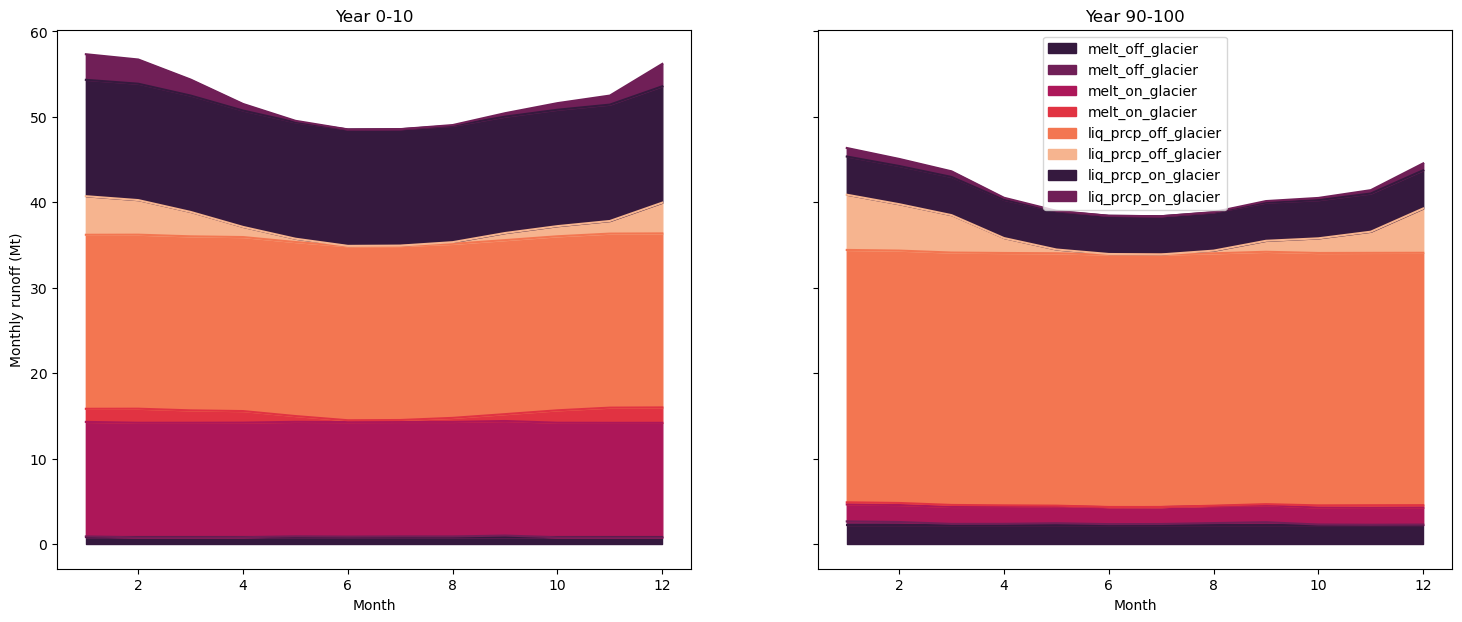

In [81]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);
df_m_s[runoff_variables].plot.area(ax=ax1, legend=False, title='Year 0-10', color=sns.color_palette("rocket"));
df_m_e[runoff_variables].plot.area(ax=ax2, title='Year 90-100', color=sns.color_palette("rocket"));
ax1.set_ylabel('Monthly runoff (Mt)'); ax1.set_xlabel('Month'); ax2.set_xlabel('Month');

In [22]:
# Dont need this (?)
gcm_list = ['CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'MPI-ESM-LR', 'NorESM1-M']
date_list = ['2023-01-12', '2023-01-23', '2023-01-17', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-25', '2023-01-25', '2023-01-25']
base = '~/Documents/Molly-thesis/Data/'
rcp='rcp26'

runoff = 'melt_on_glacier'
rcp26_melt_on = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

runoff = 'melt_off_glacier'
rcp26_melt_off = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

runoff = 'liq_prcp_on_glacier'
rcp26_liq_on = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

runoff = 'liq_prcp_off_glacier'
rcp26_liq_off = to_dict(gcm_list, runoff_stem=runoff, fpath_stem=base, which_date=date_list, which_rcp=rcp)

NameError: name 'to_dict' is not defined